In [1]:
#libraries
library(tidyverse)
library(RColorBrewer)
library(dplyr)
library(ggpubr)
library(psych)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




In [2]:
#options set up 
options(warn=-1)

In [3]:
#path to folder with files used in the report
path_files <- "C://Users//jziac//OneDrive//Documents//programovani//projekty//elite//data//data_report//"

In [4]:
#file names
players_file_name <- "nhl_player_stats.csv"
goalies_file_name <- "nhl_goalie_stats.csv"

In [5]:
#graphics set up for plots
gg_size <- 11
plot_size <- 7
size_multiplier <- 2
options(repr.plot.width = plot_size*size_multiplier, repr.plot.height = plot_size*size_multiplier)
def_plot_setup <- theme_light() + 
theme(text = element_text(size = gg_size*size_multiplier,  family = "helvetica"))
my_colours <- brewer.pal(n = 12,"Paired")
my_colours_2 <- brewer.pal(n = 12, "Set3")
my_colours_3 <- brewer.pal(n = 9, "Set1")

In [6]:
#functions used in the report

## calculates 'measure' - number of MADS (median absolute deviation) above median value for a given position 
##(defender, forward, defender and forward or goalie) for a given stat (goals per game average...)
##either for regular season or play offs
create_comparative_measure <- function(df, position_match, reg_seas, stat) {
  if (position_match == "defense") {
    match <- "D"
  }
  else if (position_match == "attack") {
    match <-"W|C"
  }
  else if (position_match == "all") {
    match <- "W|C|D"
  }
  else if (position_match == "goalie") {
    match <- "G"
  }

  df_2 <- df %>%
    group_by(season) %>%
    filter(gp > 0) %>%
    mutate(median_games = median(gp, na.rm = TRUE), median_stat = median({{ stat }}, na.rm = TRUE)) %>%
    filter(gp >= median_games)

  season_values <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    group_by(season) %>%
    summarize(
    mad = mad({{ stat }}, na.rm = TRUE), 
    median = median({{ stat }}, na.rm = TRUE)
    )

  dominance_df <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    left_join(season_values, by = "season") %>%
    mutate(measure = ({{ stat }} - median)/mad) %>%
    arrange(desc(measure))
}

create_career_measure <- function(df) {
  career_measure <- df %>%
    group_by(name) %>%
    summarize(measure = mean(measure, na.rm = TRUE), n = n()) %>%
    filter(n >= median(n))  %>%
    arrange(desc(measure))
    career_measure
}

## creates plot comparing 'measure' values for chosen players in a chosen time period
create_comparison_plot <- function(df, position, stat, player_filter, min = NULL, max = NULL, min_y = 0, max_y = 7, colour_mapping){
  if (position == "forward") {
    title_name <- "Forwards"
  }
  else if (position == "defender") {
    title_name <- "Defenders"
  }
  else if (position == "goalie") {
    title_name <- "Goalies"
  }

  if (stat == "ppg") {
    stat_name <- "Points per Game Average"
  }
  else if (stat == "gpg") {
    stat_name <- "Goals per Game Average"
  }
  else if (stat == "svp") {
    stat_name <- "Save Percentage"
  }

  if (is.null(min)) {
    min <- min(df$season_id)
  }
    min_season <- df %>%
      ungroup() %>%
      filter(season_id == min) %>%
      distinct(season) %>%
      pull(season) 
 if (is.null(max)) {
    max <- max(df$season_id)
  }
    max_season <- df %>%
      ungroup() %>%
      filter(season_id == max) %>%
      distinct(season) %>%
      pull(season) 

  df_filered <- df %>%
    filter(name %in% player_filter) %>%
    filter(season_id >= min, season_id <= max) 

  players <- df_filered %>%
    ungroup() %>%
  distinct(name) %>%
  pull(name)

  cm_filtered <- colour_mapping %>%
    filter(player %in% players) 

  plot <- df_filered %>%
    mutate(name = factor(name, levels = cm_filtered$player)) %>%
    ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
    geom_line(size = 1.5) + 
    geom_point(size = 4) +
    labs(title=paste("Between ", min_season, " and ", max_season, " Seasons"), x = "th season", colour = "player name") +
    ylim(min_y, max_y) + 
    scale_colour_manual(labels = cm_filtered$player, values = cm_filtered$colour_hex)+
    def_plot_setup

    plot
} 

## creates grid with plots from function create_comaparison_plot
## limit seasons defining individual plots are given by vector season_limits
create_era_comparison_plot <-function(df, position, stat, player_list, season_limits, title_position, max_y){
  list_plots <- list()
  colour_list <- c(my_colours, my_colours_2, my_colours_3)
  colour_mapping <- data.frame(player_list, colour_list[1:length(player_list)])
  colnames(colour_mapping) <- c("player", "colour_hex")
  for (ind in 1:(length(season_limits) - 1)) {
    min <- season_limits[ind]
    max <- season_limits[ind + 1]
    plot_period <- create_comparison_plot(df = df, 
                                          position = position, 
                                          stat = stat, 
                                          player_filter = player_list, 
                                          min = min, 
                                          max = max, 
                                          colour_mapping = colour_mapping, 
                                          max_y = max_y)
    list_plots[[ind]] <- plot_period
    }  
    plot <- ggarrange(plotlist=list_plots)
    if (stat == "ppg"){
      stat_title <- "Points per Game"
    }
    else if (stat=="gpg"){
      stat_title <- "Goals per Game"
    }
    else if (stat=="svp"){
      stat_title <- "Save Percentage"
    }
    annotate_figure(plot, 
                    top = text_grob(paste("Dominant Players through different eras - ", 
                                          title_position, " - ", stat_title), 
                                          color = "black", 
                                          face = "bold", 
                                          size = 28))
}

In [7]:
#constants
big_six <- c("Sweden", "Canada", "Russia", "Czechia", "Finland", "Canada", "USA")
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Pavel Bure", 
                    "David Pastrnak", "Mike Bossy", "Phil Esposito", "Bobby Hull", "Alexander Ovechkin", "Brett Hull", "Maurice Richard", 
                    "Jaromír Jágr", "Auston Matthews", "Jean Beliveau", "Ted Lindsay", "Andy Bathgate", "Sidney Crosby", "Elmer Lach", 
                    "Doug Bentley", "Charlie Conacher", "Syl Apps", "Howie Morenz", "Newsy Lalonde", "Joe Malone", "Cy Denneny", "Guy Lafleur")
defender_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Erik Karlsson", "Denis Potvin", "Roman Josi", "Red Kelly", "Nicklas Lidström", 
                      "Doug Harvey", "King Clancy", "Eddie Shore", "Brad Park", "Cale Makar", "Al MacInnis", "Paul Reinhart", 
                      "Brian Leetch", "Pierre Pilote", "Bill Gadsby", "Flash Hollett", "Pat Egan", "Ken Randall", "Sprague Cleghorn", 
                      "Buck Boucher", "Kris Letang", "Victor Hedman")
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante",  "Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", 
                    "Glenn Hall", "Johnny Bower", "Bernie Parent", "Ken Dryden", "Roberto Luongo", "Tuukka Rask", "Ben Bishop", "Carey Price",
                    "Lorne Worsley")
 eras_limits <- c(seq(1, 106,20), 106)
 eras_limits_g <- c(seq(36, 106,20), 106)

In [8]:
#loading players data set and grouping season data for one player together (in case he plays for more teams in one season)
player_data <- read_csv(paste(path_files, players_file_name, sep = ""))
player_data <- player_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp) %>%
  group_by(
    u_id, name, season_id, season, handedness, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    g = sum(g, na.rm = TRUE), 
    a = sum(a, na.rm = TRUE), 
    tp = sum(tp, na.rm = TRUE), 
    plus_minus = sum(plus_minus, na.rm = TRUE), 
    pm = sum(pm, na.rm = TRUE)
  ) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp, avg_a = a/gp)
  head(player_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...32`
* `id` -> `id...34`
Rows: 100078 Columns: 35
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (7): name, position, handedness, contract_end, captaincy, nationality,...
dbl  (26): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (1): catches
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'handedness', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,g,a,tp,plus_minus,pm,avg_g,avg_p,avg_a
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,David Printz,89,2005-2006,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,89,2005-2006,L,Sweden,0,D,1,1,0,0,0,0,0,0.000,0.00,0.000
18,David Printz,90,2006-2007,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,90,2006-2007,L,Sweden,0,D,1,12,0,0,0,-3,4,0.000,0.00,0.000
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,0,0,0,0,0,0,0,NaN,NaN,NaN
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,1,8,1,1,2,1,2,0.125,0.25,0.125


In [9]:
#loading players data set and grouping season data for one player together (in case he plays for more teams in one season)
goalie_data <- read_csv(paste(path_files, goalies_file_name, sep = ""))
goalie_data <- goalie_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  group_by(
    u_id, name, season_id, season, catches, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    ga = sum(ga, na.rm = TRUE), 
    so = sum(so, na.rm = TRUE),
    svs = sum(svs, na.rm = TRUE), 
    w = sum(w, na.rm = TRUE), 
    l = sum(l, na.rm = TRUE),
    t = sum(t, na.rm = TRUE),
    toi = sum(toi, na.rm = TRUE),
  ) %>%
  mutate(gaa = round(ga/gp, 4), svp = round(svs/(ga + svs), 4))
  head(goalie_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...37`
* `id` -> `id...39`
Rows: 11006 Columns: 40
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (6): name, position, catches, contract_end, nationality, season
dbl  (31): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (2): handedness, captaincy
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'catches', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,ga,so,svs,w,l,t,toi,gaa,svp
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,0,5,11,0,134,1,4,0,297,2.2000,0.9241
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,1,41,73,5,955,23,8,6,2227,1.7805,0.9290
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,0,6,17,0,153,2,4,0,361,2.8333,0.9000
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,1,58,131,4,1498,33,13,8,3409,2.2586,0.9196
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,0,0,0,0,0,0,0,0,0,NaN,NaN
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,1,71,159,8,1900,37,24,8,4088,2.2394,0.9228


## Data Quality Check

In [10]:
print("Players: ")
player_data %>%
  keep(is.numeric) %>%
  describe()
print("Goalies: ")
goalie_data %>%
  keep(is.numeric) %>%
  describe()

[1] "Players: "


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
u_id,1,92004,63430.8967001,7.518178e+04,3.163800e+04,48545.3288408,3.402419e+04,18,647942,647924,1.8031519,3.3775924,2.478616e+02
season_id,2,92004,75.6403417,2.424306e+01,8.000000e+01,78.6916472,2.223900e+01,1,107,106,-0.9788991,0.3917288,7.992527e-02
active,3,92004,0.2060780,4.044893e-01,0.000000e+00,0.1326015,0.000000e+00,0,1,1,1.4532833,0.1120336,1.333533e-03
regular_season,4,92004,0.5000000,5.000027e-01,5.000000e-01,0.5000000,7.413000e-01,0,1,1,0.0000000,-2.0000217,1.648424e-03
gp,5,92004,24.6822529,2.932246e+01,8.000000e+00,20.9419325,1.186080e+01,0,86,86,0.8310207,-0.9497745,9.667120e-02
g,6,92004,4.3453980,7.999046e+00,0.000000e+00,2.3640563,0.000000e+00,0,92,92,2.7185802,8.9908261,2.637150e-02
a,7,92004,7.0659754,1.178171e+01,1.000000e+00,4.3135699,1.482600e+00,0,163,163,2.3868124,7.1383295,3.884229e-02
tp,8,92004,11.4113734,1.900757e+01,2.000000e+00,6.9350443,2.965200e+00,0,215,215,2.3483185,6.5583249,6.266475e-02
plus_minus,9,92004,-0.1652319,7.938569e+00,0.000000e+00,-0.2866284,0.000000e+00,-82,124,206,0.8855482,14.9351793,2.617212e-02


[1] "Goalies: "


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
u_id,1,10428,7.436080e+04,8.875121e+04,31635.00000,5.835103e+04,3.894345e+04,7,1002971.00,1002964.00,1.967384,6.7361050,8.691080e+02
season_id,2,10428,7.703165e+01,2.350359e+01,82.00000,8.001270e+01,2.223900e+01,1,107.00,106.00,-1.028536,0.6851760,2.301621e-01
active,3,10428,2.019563e-01,4.014790e-01,0.00000,1.275168e-01,0.000000e+00,0,1.00,1.00,1.484586,0.2040165,3.931537e-03
regular_season,4,10428,5.000000e-01,5.000240e-01,0.50000,5.000000e-01,7.413000e-01,0,1.00,1.00,0.000000,-2.0001918,4.896551e-03
gp,5,10428,1.357873e+01,1.951075e+01,2.00000,9.662872e+00,2.965200e+00,0,79.00,79.00,1.407516,0.7900809,1.910616e-01
ga,6,10428,3.734762e+01,5.442644e+01,7.00000,2.626546e+01,1.037820e+01,0,310.00,310.00,1.490909,1.2357146,5.329781e-01
so,7,10428,7.650556e-01,1.690506e+00,0.00000,3.313758e-01,0.000000e+00,0,22.00,22.00,3.298826,14.6288612,1.655450e-02
svs,8,10428,3.088797e+02,4.895693e+02,22.00000,1.994265e+02,3.261720e+01,0,2376.00,2376.00,1.663590,1.7545287,4.794173e+00
w,9,10428,5.789030e+00,9.342003e+00,0.00000,3.660834e+00,0.000000e+00,0,48.00,48.00,1.806639,2.5612649,9.148281e-02


Looking on the min and max values of all stat in our data set, they are all in accordance with known NHL records. Further, we can derive from the table that not one of them follows the normal distribution. As it can be expected the data for all of the stat categories is skewed to the right, which is also in accordance with our expectation that there are smaller subset of players who have dramatically higher values of these statistical categories.  

# Analysis of NHL Seasons from 1917 to 2023

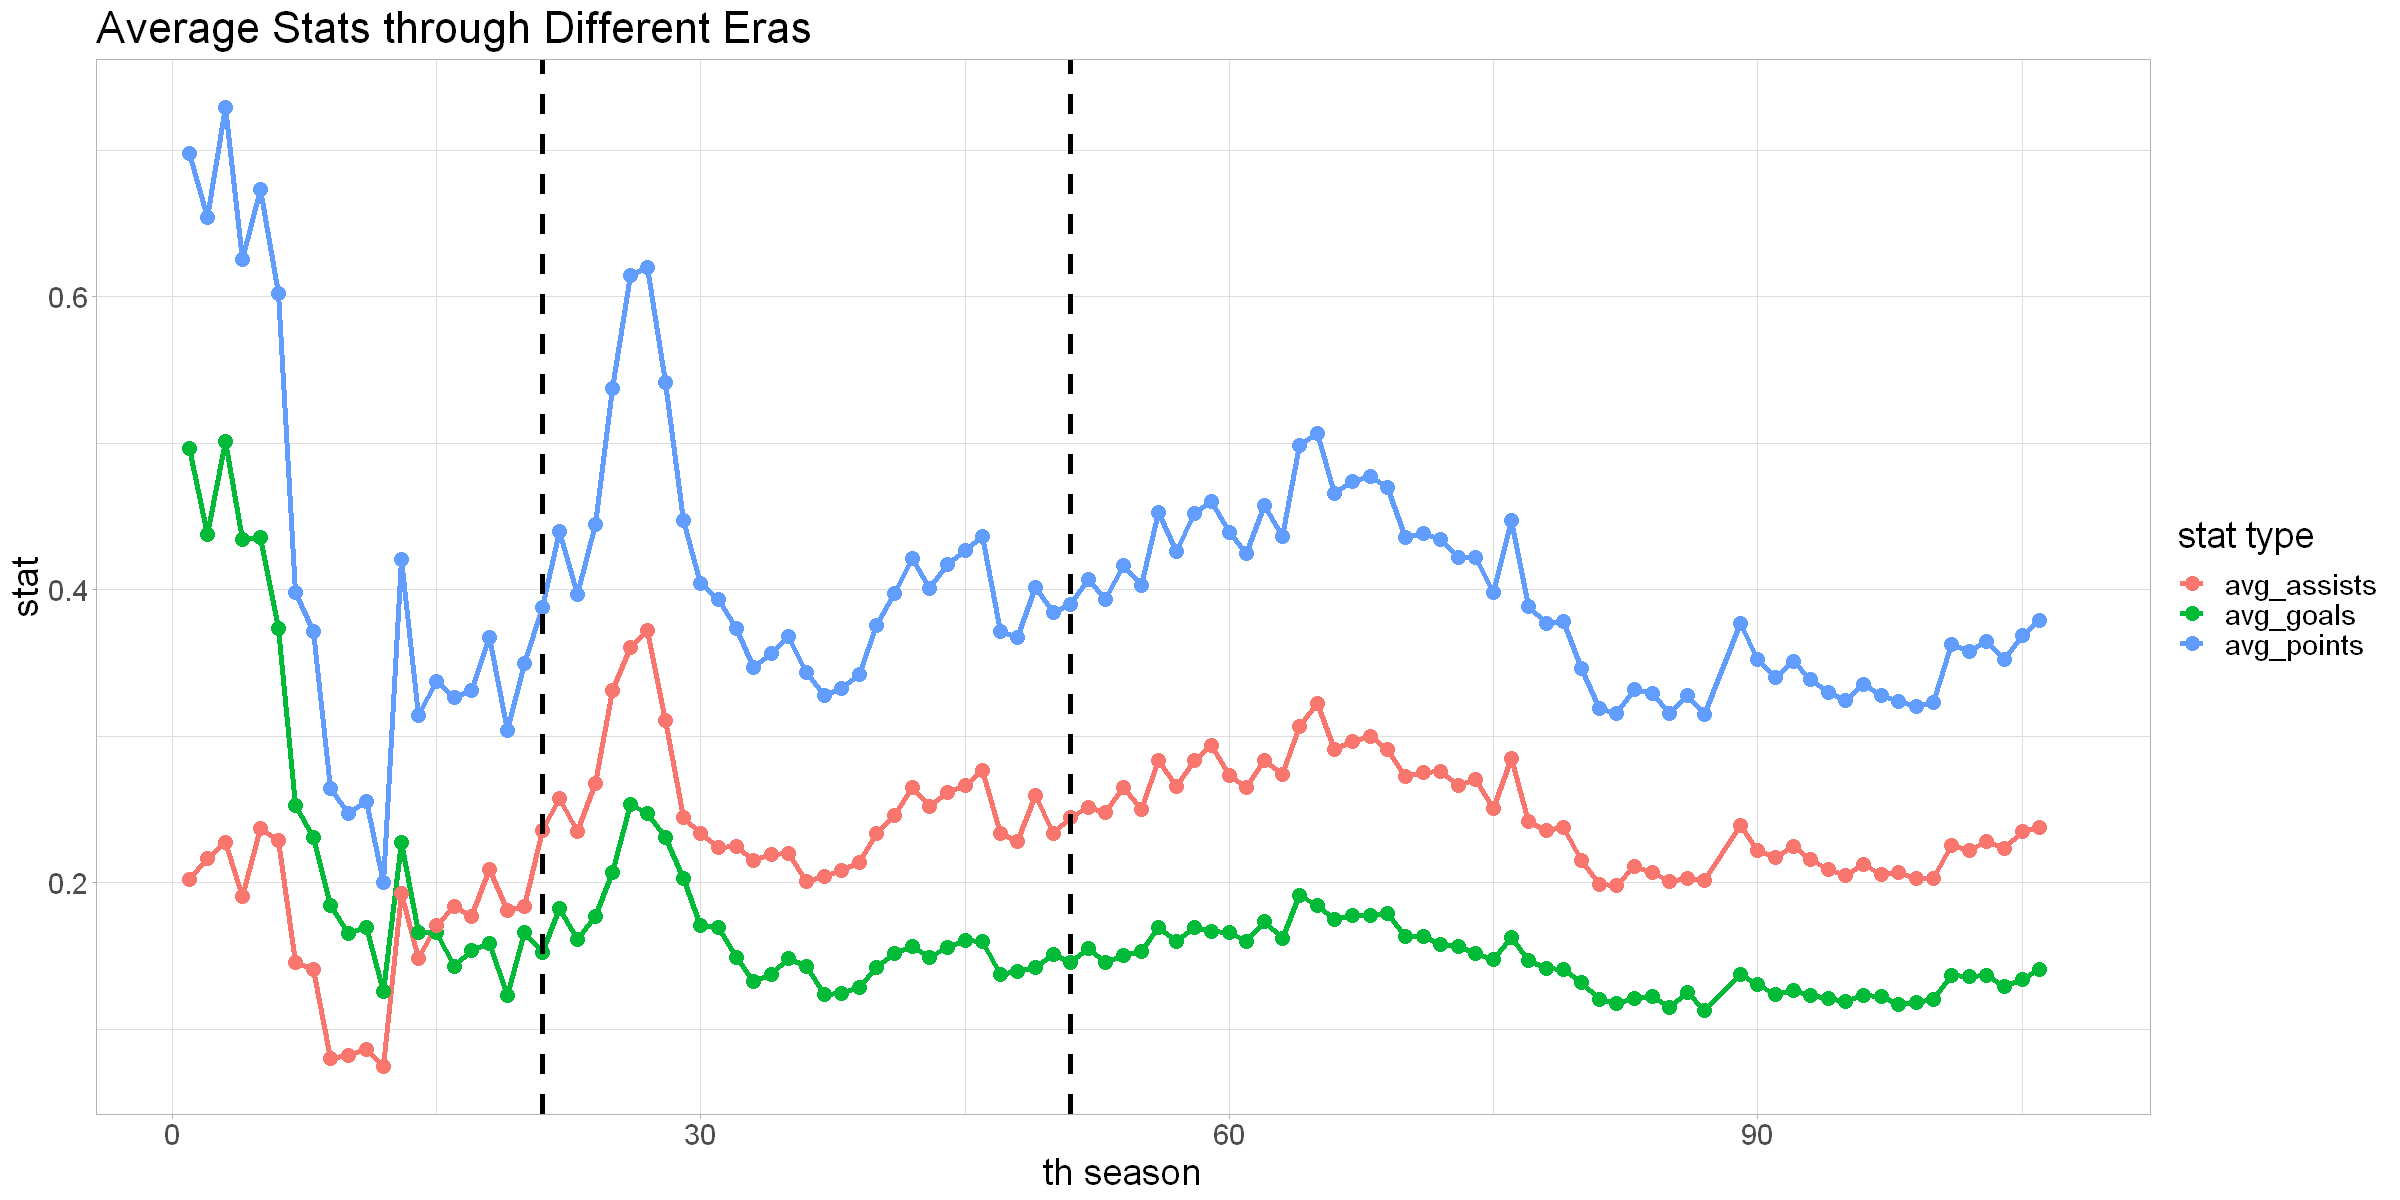

In [11]:
options(repr.plot.width = 20, repr.plot.height=10)
player_data %>%
  filter(regular_season == 1) %>%
  group_by(season_id) %>%
  summarize(
    avg_goals = mean(avg_g, na.rm=TRUE), 
    avg_points = mean(avg_p, na.rm=TRUE), 
    avg_assists = mean(avg_a, na.rm = TRUE)
    ) %>%
  pivot_longer(!season_id, names_to = "type_stat", values_to = "avg") %>%
  ggplot(., aes(x = season_id, y = avg, colour = type_stat)) +
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  labs(title= "Average Stats through Different Eras", color = "stat type", y = "stat", x = "th season") +
  geom_vline(xintercept = 21, size = 1.5, linetype = "dashed") +
  geom_vline(xintercept = 51, size = 1.5, linetype = "dashed") + 
  scale_fill_manual(values = my_colours) +
  def_plot_setup 

The table above, shows average average points, goals and assits per game through NHL history. In early history of the competition, there was a high number of rule changes that dramatically changed average scoring from season to season. Another reason for variability in the first 20 seasons of NHL was a low number of teams and thus also players. The two vertical dashed lines then signify beginning and end of original 6 team era. After the first NHL expansion since the end of 1930s at the end of the 1960s we can see steady increase in average player scoring per game caused most likely by decrease of  quality in he league after the expension culmainating in 1980s in the era of Wayne Gretzky, Mike Bossy and other legendary high scoring players of that time. Since then we can, on the other hand,  see steady decrease in scoring powered by increase of the size of the equipment of goalies and changes in the hockey tactics as for example very popular neutral zone trap first introduced by New Jersey Devils in the middle of the 1990s decade. Nevertheless in the last 20 several steps were conducted in order to increase scorign again as for example introduction of two line pass which makes the neutral zone trap less viable strategy or decrease in size of goalie equipment which resulted in renewed increase in scoring in last few years. 

### Dominant Player Performances

In the following section, the most dominant performances of players in several different stats (goals, assists, total, points, plus minus for players and save percentage and average goals against for goalkeepers) careerwise and seasonwise are compared. Given that scoring in NHL games varied quite significantly across time given changes in rules and equipment as can be noted in previous graph, the seasonal statistics of individual players are compared not in absolute terms but instead the individual seasonal stats of one player are compared with peofrmances of other players in the same season. Secondly, given to different nature of different positions in hockey, in our case the fact that forwards are expected to score much more than defenders, the stats are also compared separatedly for those two positions. The metric which measures the relative performance is then number of mean absolute deviations from median for a given season. 

#### Points Per Game - Forwards

##### Distribution of Points Per Game by Season

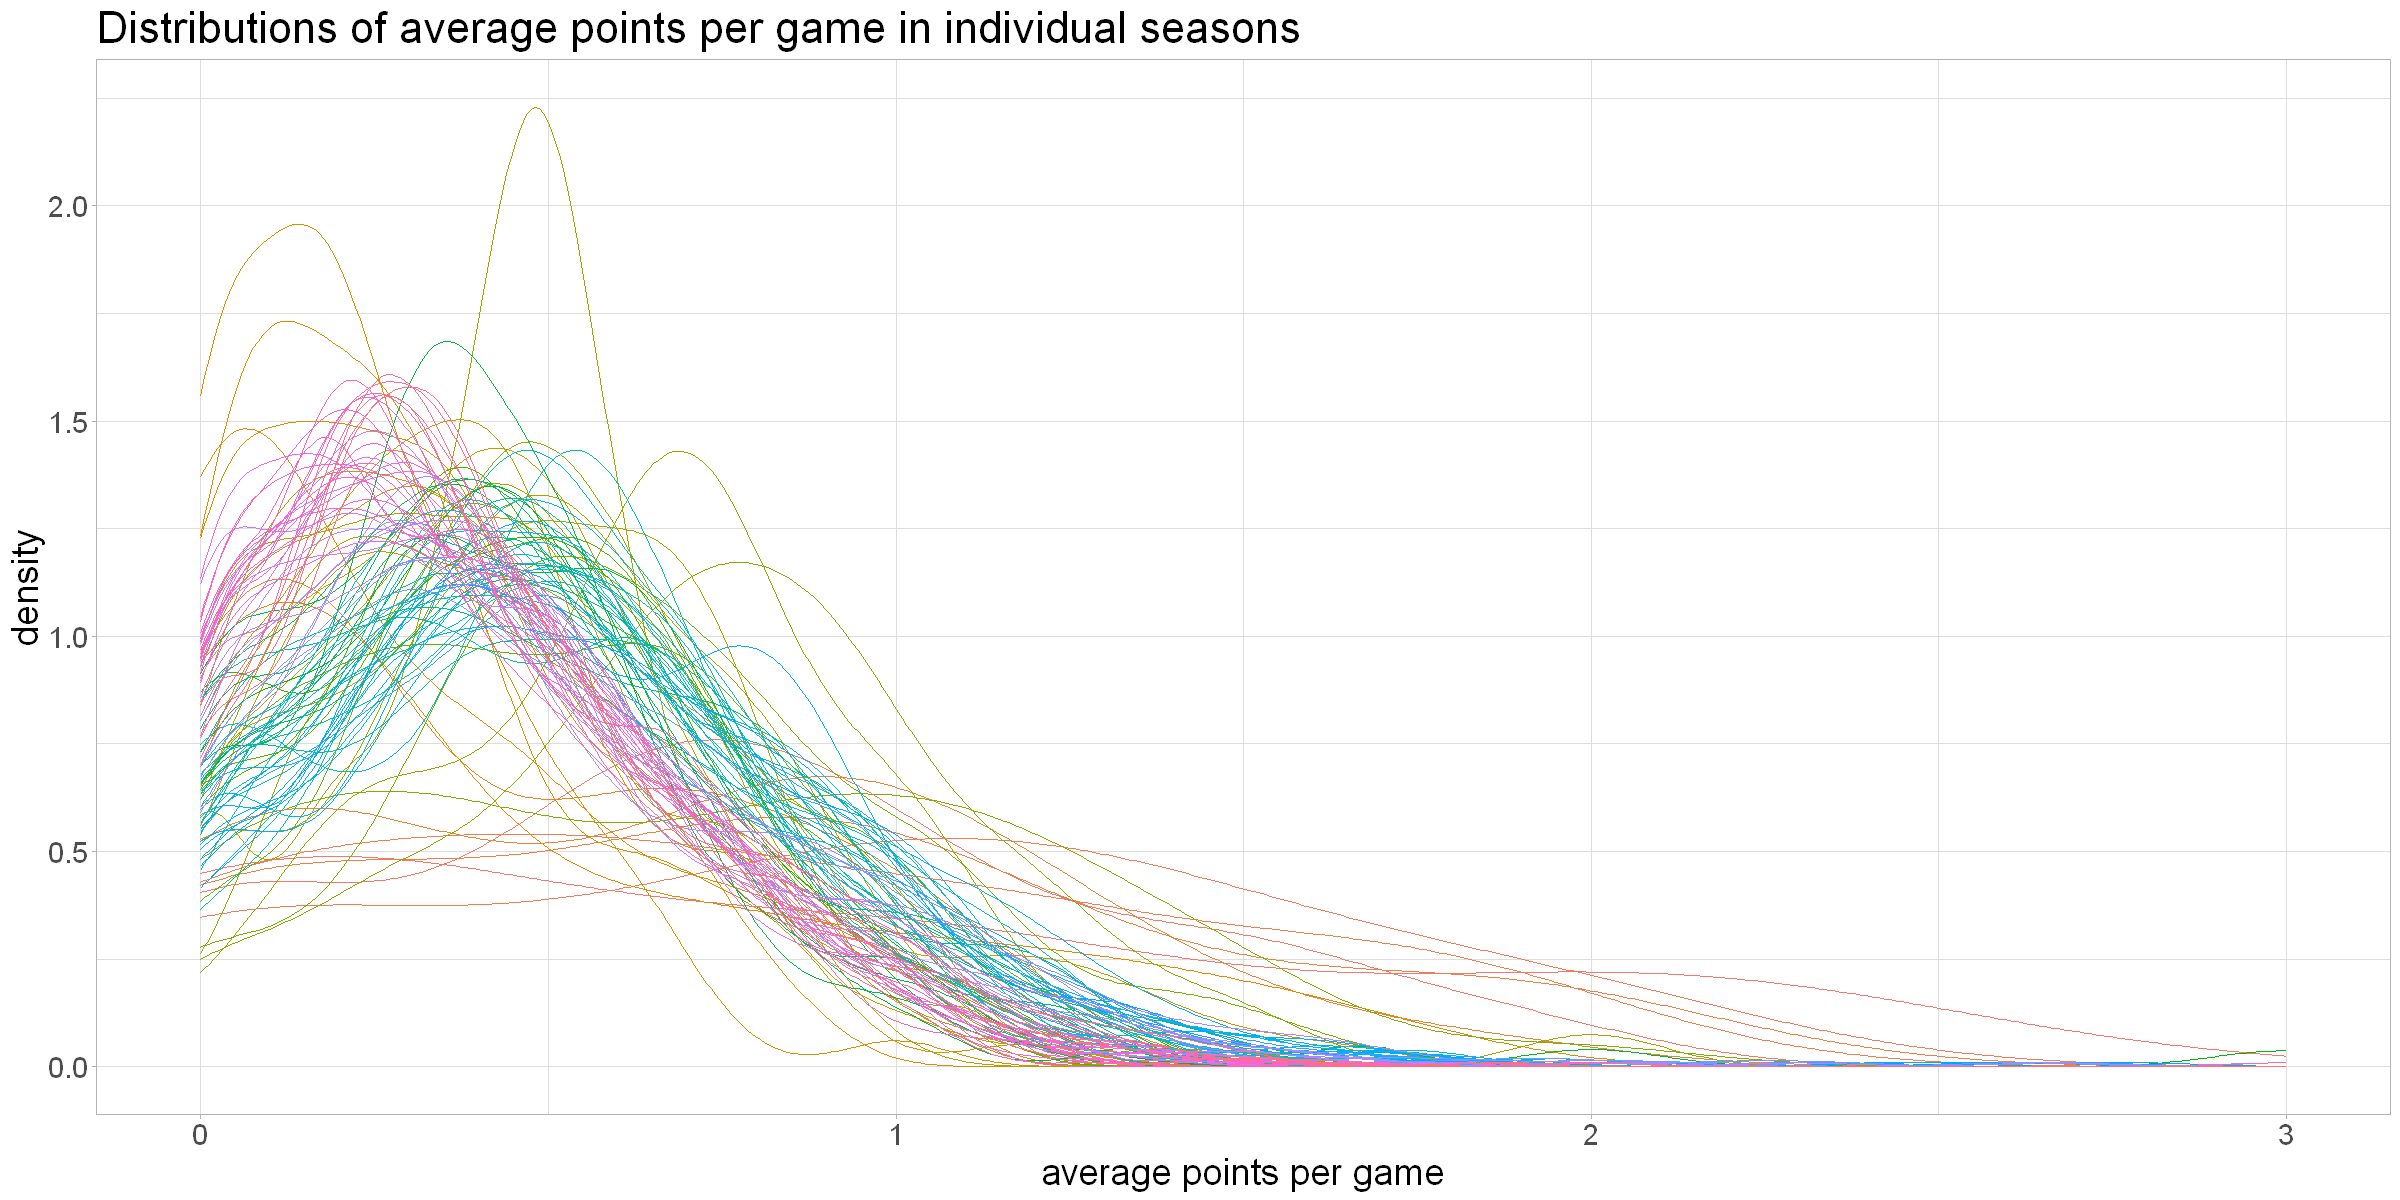

In [12]:
player_data %>%
  filter(regular_season == 1) %>%
  filter(grepl("W|C", position)) %>%
  ggplot(., aes(x = avg_p, colour = season)) + 
  geom_density() + 
  labs(x="average points per game", title="Distributions of average points per game in individual seasons") + 
  def_plot_setup + 
  theme(legend.position = 'none')

In the graph above, we can see distributions of points per game for all seasons in NHL history. From the graph, it is evident that the distribution is not even close to being symmetric but that it is right skewed instead. Most of the players seem to be concentrated bellow 0.5 points per game but each season the best players  generally achieve twice as high averages. 

##### Best Seasons

In [13]:
dominance_p_f <- create_comparative_measure(player_data, "attack", 1, avg_p)
head(dominance_p_f, 10)

u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,...,plus_minus,pm,avg_g,avg_p,avg_a,median_games,median_stat,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9679,Mario Lemieux,76,1992-1993,R,Canada,0,C,1,60,...,55,38,1.1500000,2.666667,1.516667,25,0.3525269,0.3344675,0.4755952,6.550925
9678,Wayne Gretzky,69,1985-1986,L,Canada,0,C,1,80,...,71,46,0.6500000,2.687500,2.037500,19,0.3725490,0.3363613,0.6018868,6.200514
9678,Wayne Gretzky,68,1984-1985,L,Canada,0,C,1,80,...,100,52,0.9125000,2.600000,1.687500,19,0.4000000,0.3333604,0.5887491,6.033263
9678,Wayne Gretzky,67,1983-1984,L,Canada,0,C,1,74,...,78,39,1.1756757,2.770270,1.594595,19,0.3636364,0.3695186,0.5767591,5.936132
183442,Connor McDavid,104,2020-2021,L,Canada,1,C,1,56,...,21,20,0.5892857,1.875000,1.285714,23,0.3000000,0.2471000,0.4166667,5.901794
9679,Mario Lemieux,79,1995-1996,R,Canada,0,C,1,70,...,10,54,0.9857143,2.300000,1.314286,24,0.3070720,0.3183360,0.4444444,5.828921
9678,Wayne Gretzky,65,1981-1982,L,Canada,0,C,1,80,...,80,26,1.1500000,2.650000,1.500000,17,0.4067797,0.3619798,0.6388889,5.555865
9678,Wayne Gretzky,66,1982-1983,L,Canada,0,C,1,80,...,61,59,0.8875000,2.450000,1.562500,19,0.3846154,0.3403707,0.5844156,5.481037
9679,Mario Lemieux,72,1988-1989,R,Canada,0,C,1,76,...,41,100,1.1184211,2.618421,1.500000,19,0.3378378,0.3818818,0.5613097,5.386775


In the table above the best seasons in terms of dominace over their peers in average points per game for forwards can be seen. In order for the player to be included he had to play at least median number of matches in a given season. Unsuprisingly, for everyone faimiliar with hockey history, most of the leading positions are occupied by the "Great One" Wayne Gretzky, altough all time most dominant season according to our metric is held by a different all time great player Mario Lemieux with his performance in 1992-1993 season. In this season he achieved point per game average six MADs over league median for forwards with 2.6 points per game.  Only player that interrupts the top 10  performance in season dominance of these two players is then Connor McDavid.

##### Career Highs

In [14]:
career_p_dominance_f <- create_career_measure(dominance_p_f)
head(career_p_dominance_f, 10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.400902,13
Wayne Gretzky,4.130183,20
Connor McDavid,3.966680,8
Sidney Crosby,2.987846,17
Peter Forsberg,2.859442,11
Mike Bossy,2.725810,10
Artemi Panarin,2.693575,8
Auston Matthews,2.657353,7
Leon Draisaitl,2.605054,9


Looking at the career averages of seasonal dominance measure we can see similiar picture to table with individual seasonal performances. The same 3 players occupy first 3 positions.  There are only included the players that played at least in median number of seasons in a league history, neveretheless,  there is still an overpresentation of players that are not yet retired and are still in their prime caused by the fact that  the weaker performances at the end of their career do not bring down their career averages yet. On the other hand, this makes career average of 4.40 and 4.27 of Wayne Gretzky and Mario Lemieux respectively even more impressive since even though their average measure value includes several seasons played after their peak they still hold first two positions. 

In [15]:
career_p_dominance_f %>%
filter(n > median(n)) %>%
head(10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.400902,13
Wayne Gretzky,4.130183,20
Sidney Crosby,2.987846,17
Peter Forsberg,2.859442,11
Mike Bossy,2.725810,10
Yevgeni Malkin,2.514443,17
Eric Lindros,2.513617,12
Nathan MacKinnon,2.480424,10
Joe Sakic,2.467718,19


Removing the players playing less than 10 season and thus keeping mostly retired players, we can see even more than 1 MAD over median drop between Wayne Gretzky on the secodn position and next player Sidney Crosby. Other players in the top 10 are much closer in the average 'measure' value. In the top 10 there can be found likes  of Mike Bossy, Peter Forsberg or Eric Lindors, players which careers were greatly shortened by serious injuries. On the other hand there also players like  Jaromir Jagr or Joe Sakic present who even though impressively played close or over 20 season in the league still find a place in a top 10 players with highest career average of the 'measure'.

##### Comparison of Player Careers across Different Eras

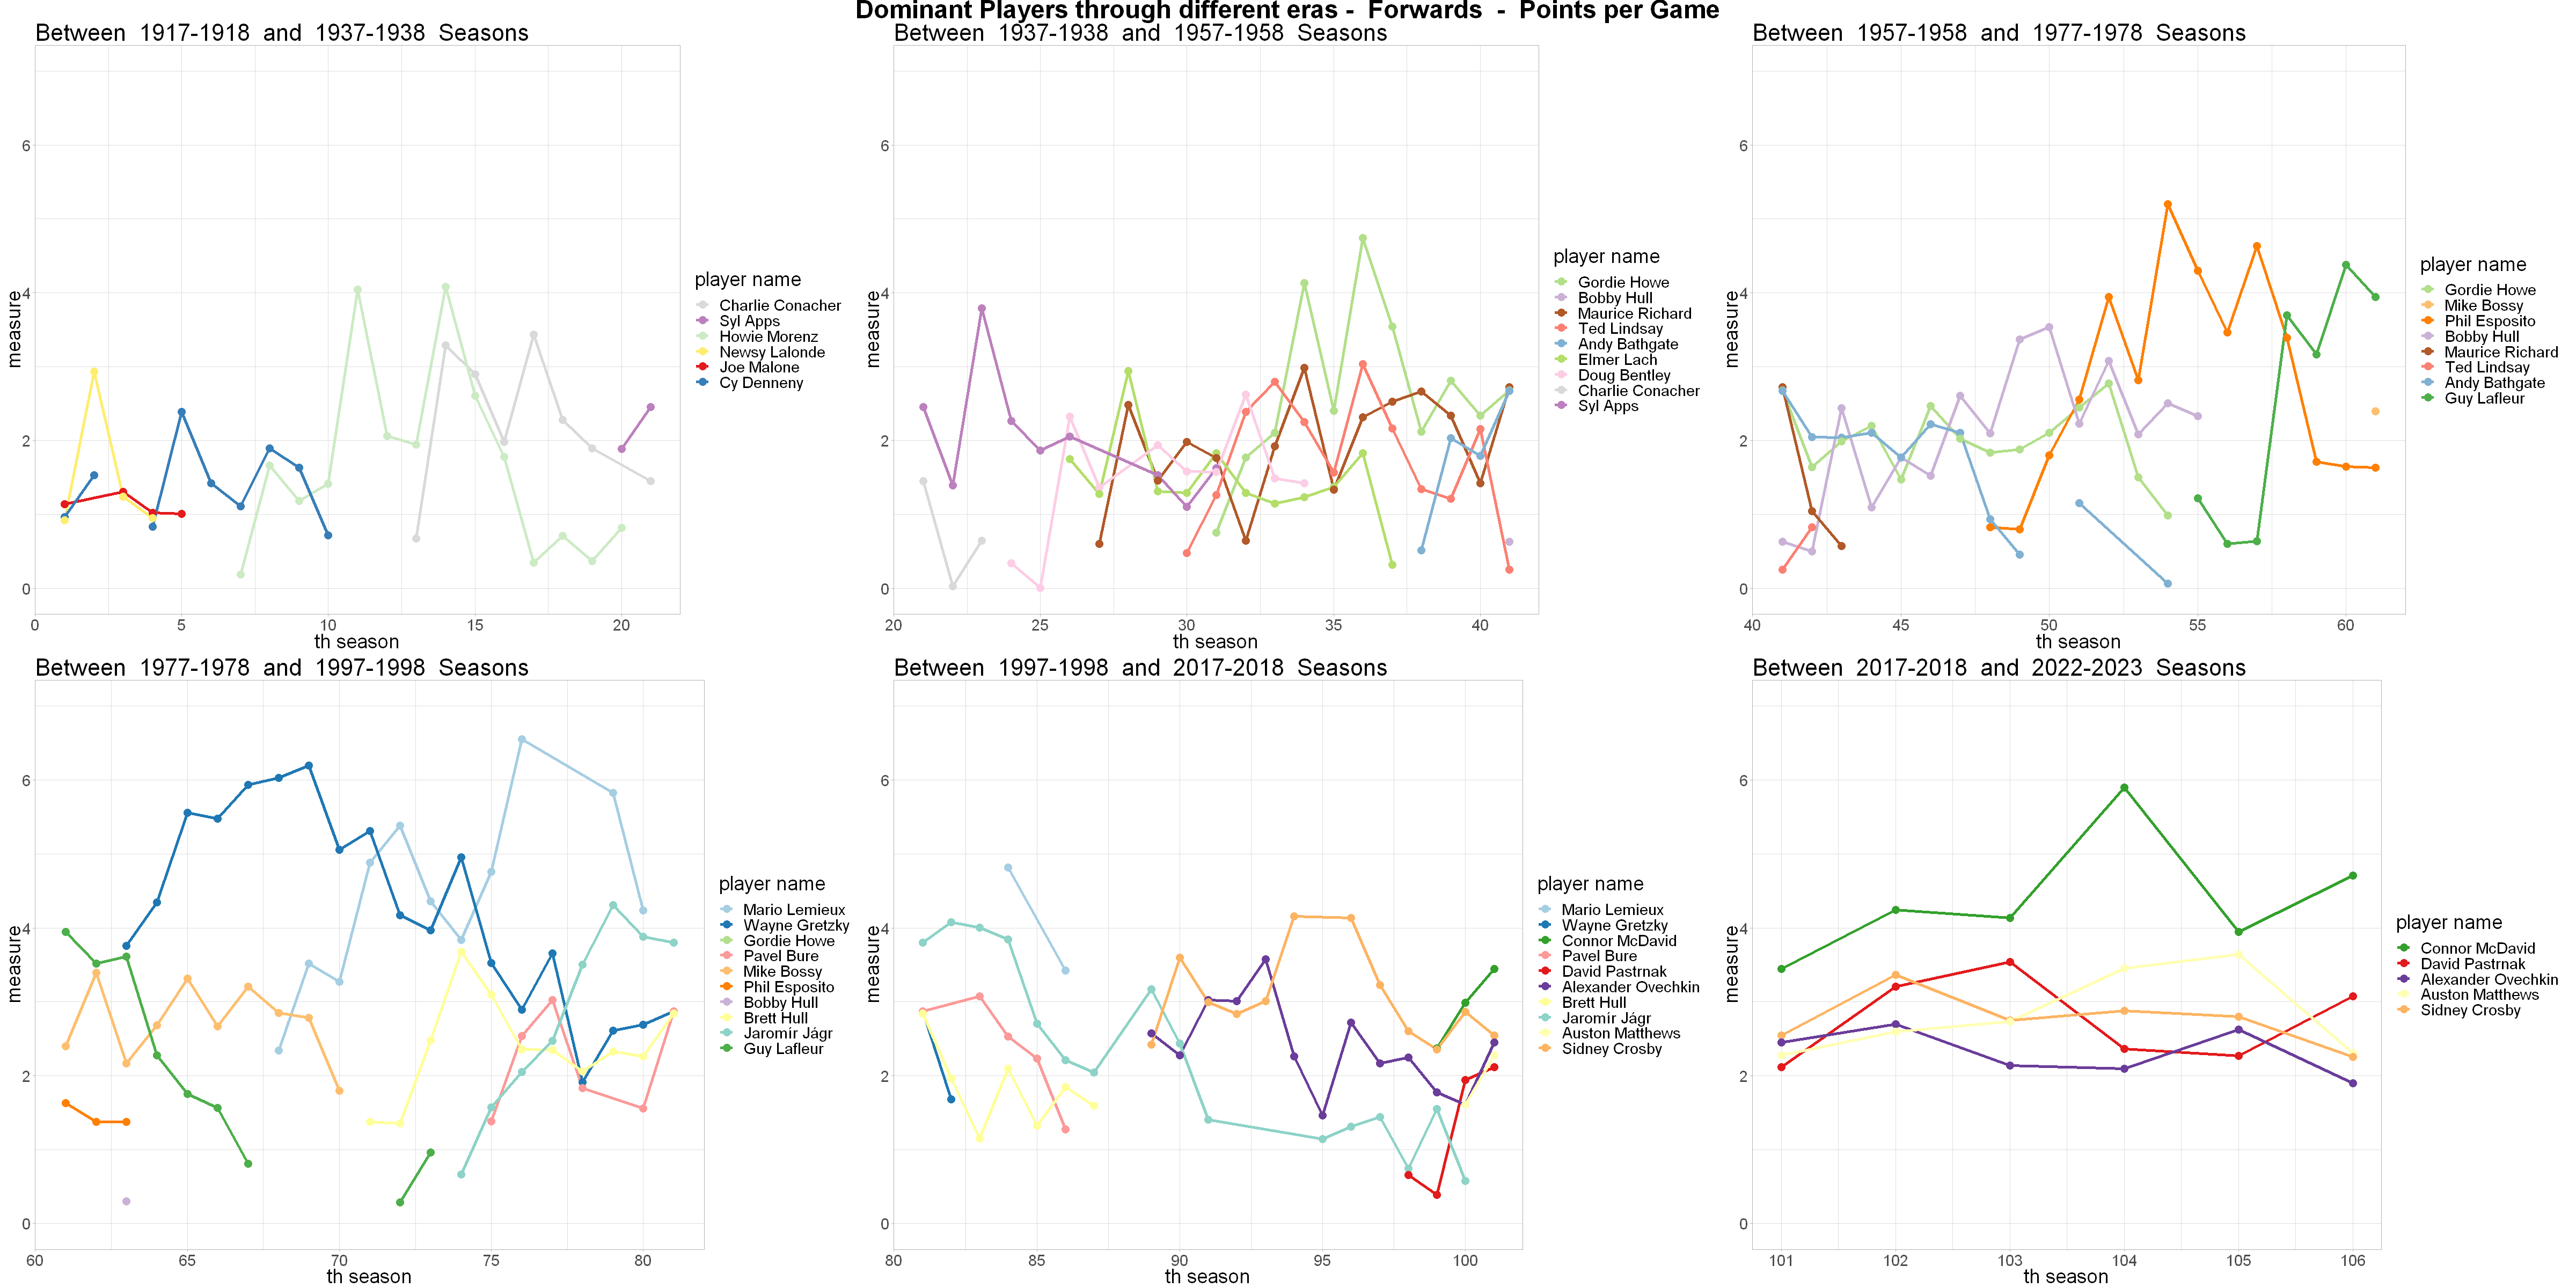

In [16]:
options(repr.plot.width = 40, repr.plot.height = 20)
create_era_comparison_plot(df = dominance_p_f, 
                           position = "forward", 
                           stat = "ppg", 
                           player_list = forward_legends, 
                           season_limits = eras_limits, 
                           title_position = "Forwards", 
                           max_y = 7)


Since career averages include do not show clear picture of player dominance at the peak of their career it can be also interesting to look at year by year performances of selected players from different eras of the league. From the look at the  performances across their careers, we can approximately divide them in 3 tiers. In the highest head and shoulders above others with maybe the exception of Connor Mcdavid, are Mario and Wayne Gretzky players that spent most of their career over 4 MADs in points per game over the median stat and on their peak they were over 6 MAD over the league median. In the next tier we can include players as Howie Morenz, Gordie Howe, Phil Esposito or more recently Jaromir Jagr, Sidney Crosby and Connor McDavid who also consistently got across 4 MAD over median threshold even though they did not achieve career heights of Wayne and Mario. An on the third tier there are other players who were the peak performers of their time but did not achieve all time career peaks of the likes from the previous two tiers as for example Bobby Hull in the 1960s, Mike Bossy in 1980s or more recently Alexander Ovechkin or Auston Matthews in the present. 

#### Goals per Game - Forwards

##### Distribution of Goals per Game by Season

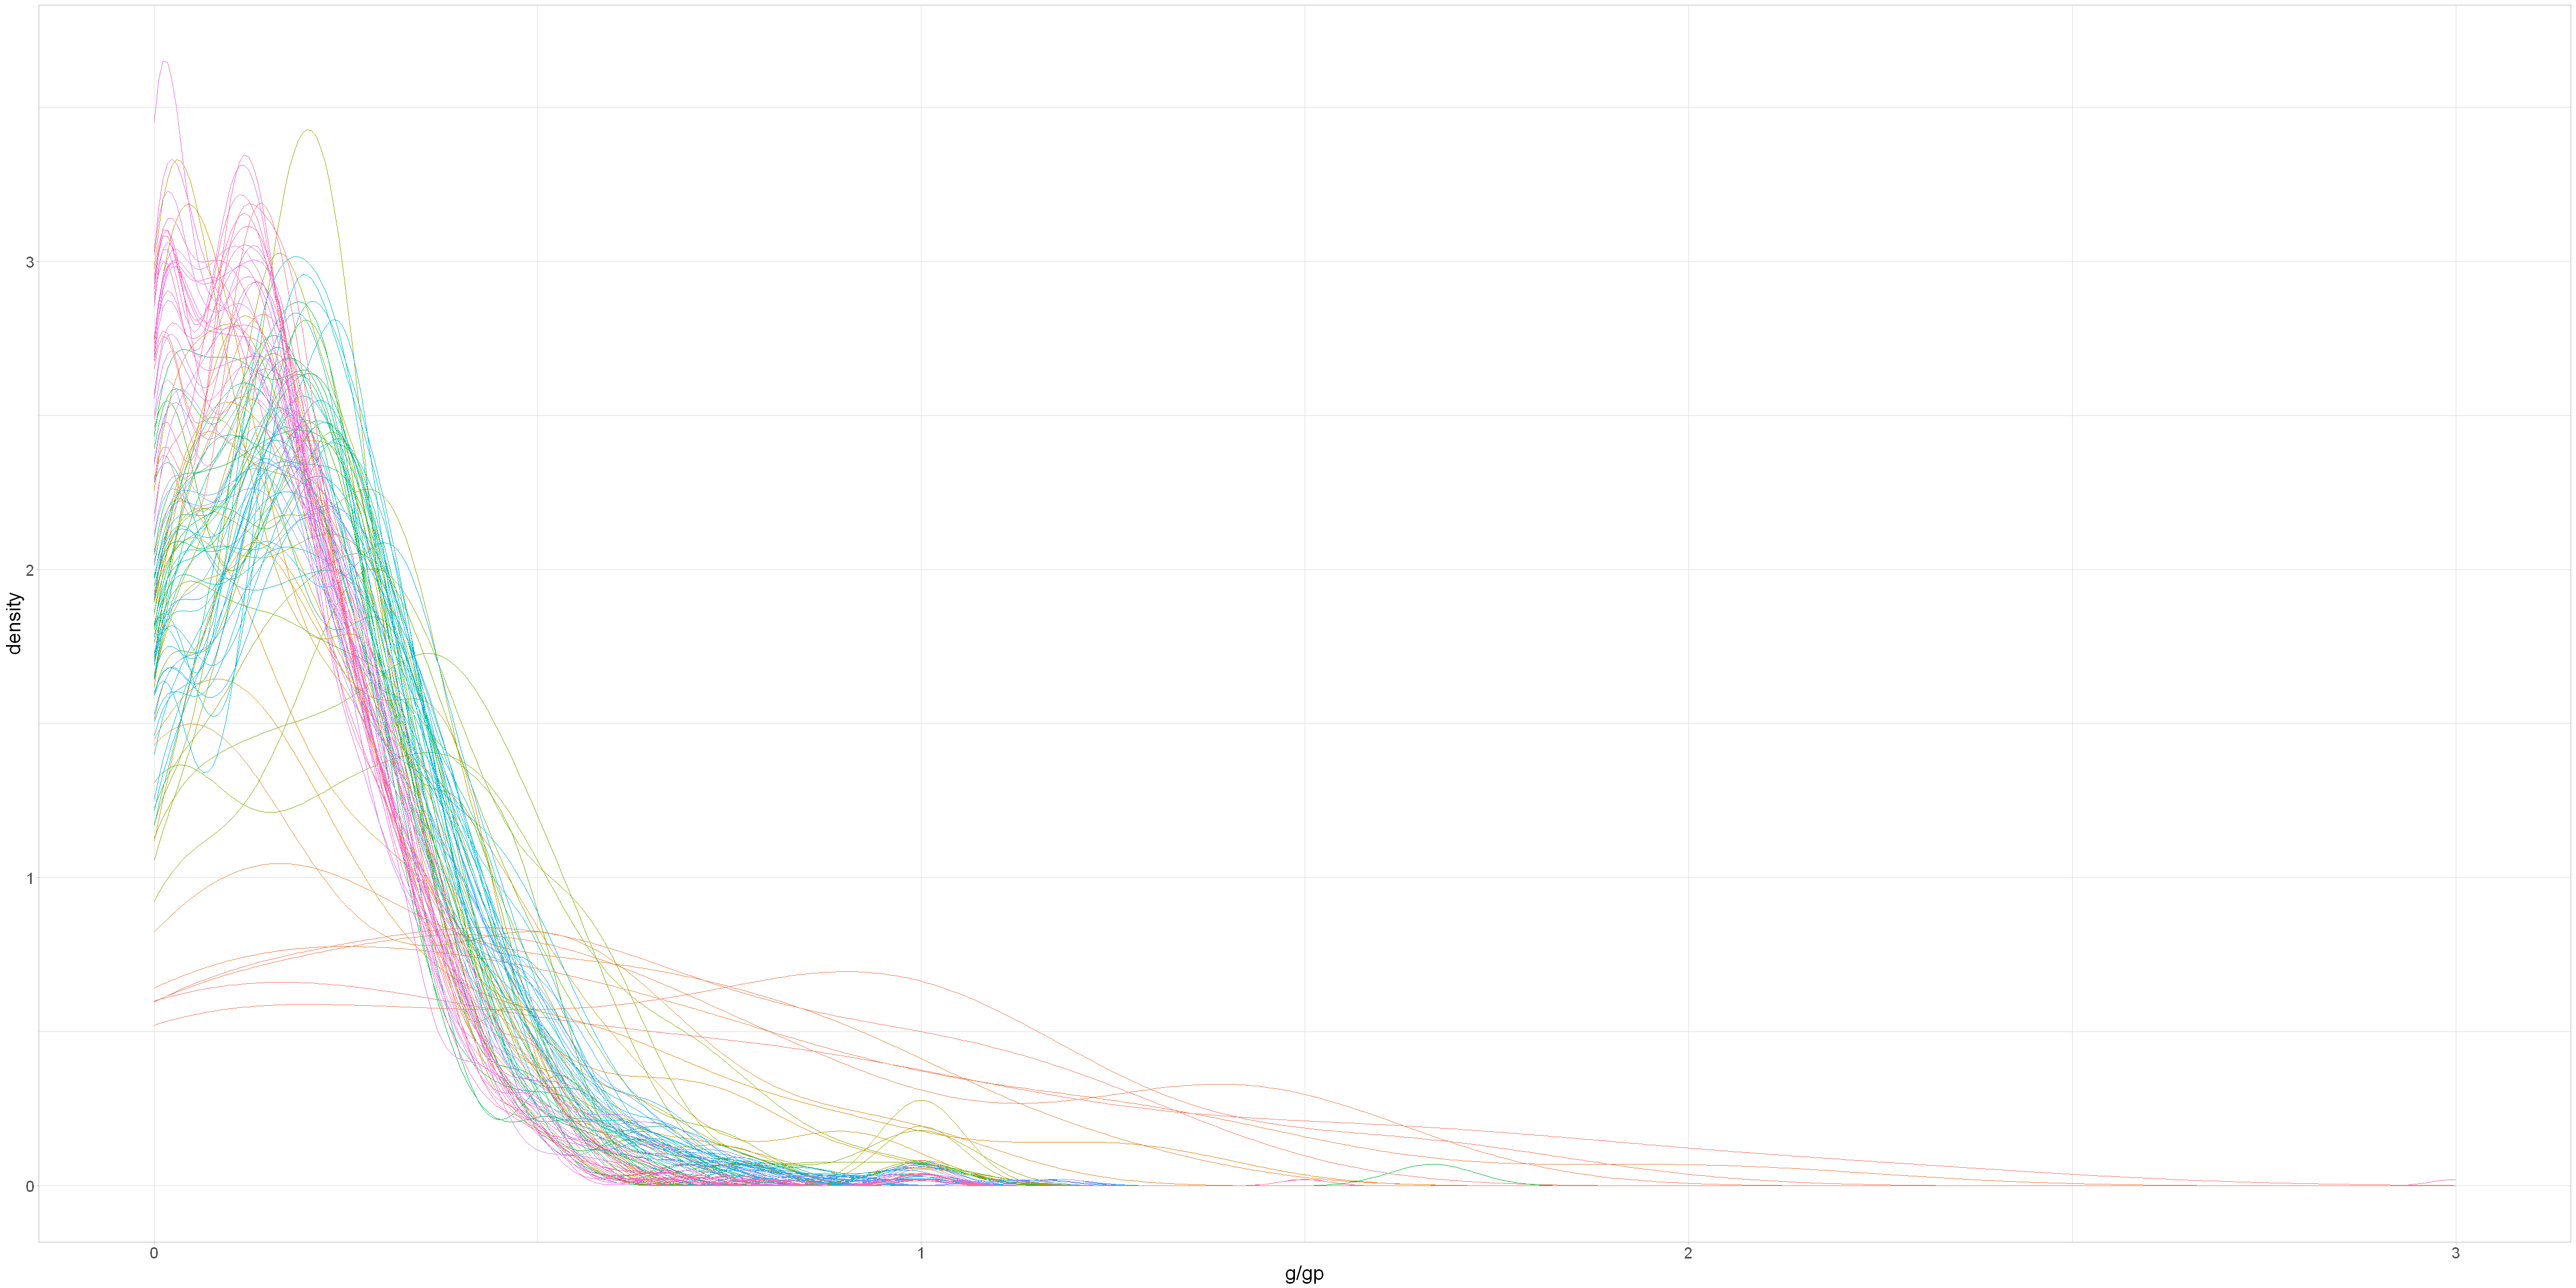

In [17]:
player_data %>%
  filter(regular_season == 1) %>%
  filter(grepl("W|C", position)) %>%
  ggplot(., aes(x = g/gp, colour = season)) +
  labs(colour="") +  
  geom_density() + 
  def_plot_setup + 
  theme(legend.position = 'none')

##### Best Seasons

In [18]:
dominance_g_f <- create_comparative_measure(player_data, "attack", 1, avg_g)
head(dominance_g_f, 10)

u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,...,plus_minus,pm,avg_g,avg_p,avg_a,median_games,median_stat,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21341,Brett Hull,74,1990-1991,R,USA,0,RW,1,78,...,23,22,1.1025641,1.679487,0.5769231,19.5,0.11111111,0.1344392,0.2094298,6.643409
9679,Mario Lemieux,76,1992-1993,R,Canada,0,C,1,60,...,55,38,1.1500000,2.666667,1.5166667,25.0,0.11764706,0.1485949,0.2039676,6.366521
22943,Phil Esposito,54,1970-1971,L,Canada,0,C,1,78,...,71,71,0.9743590,1.948718,0.9743590,36.0,0.10000000,0.1207312,0.2432432,6.055731
21320,Cam Neely,77,1993-1994,R,Canada,0,RW,1,49,...,12,54,1.0204082,1.510204,0.4897959,27.0,0.09836066,0.1417368,0.1956002,5.819291
9678,Wayne Gretzky,67,1983-1984,L,Canada,0,C,1,74,...,78,39,1.1756757,2.770270,1.5945946,19.0,0.11842105,0.1606521,0.2445724,5.795774
22943,Phil Esposito,55,1971-1972,L,Canada,0,C,1,76,...,55,76,0.8684211,1.750000,0.8815789,37.0,0.10256410,0.1147660,0.2112676,5.726027
9679,Mario Lemieux,79,1995-1996,R,Canada,0,C,1,70,...,10,54,0.9857143,2.300000,1.3142857,24.0,0.09090909,0.1431081,0.1891892,5.565898
9679,Mario Lemieux,72,1988-1989,R,Canada,0,C,1,76,...,41,100,1.1184211,2.618421,1.5000000,19.0,0.10526316,0.1635433,0.2272574,5.449099
21342,Bobby Hull,50,1966-1967,L,Canada,0,LW,1,66,...,28,52,0.7878788,1.212121,0.4242424,13.5,0.11269841,0.1028047,0.2291667,5.434696


Looking at the most dominant season in regards to goals scored, we can again see the familiar names of Mario Lemieux  and Wayne Gretzky in the top 10, nevertheless the first position is held by a different player  Brett Hull for his performance in 1990-1991 season.  In general, there is much higher variability in top ten in comparison with average point per game table. There are in total 7 different players in the top 10. 

##### Highest Career Averages

In [19]:
career_g_dominance_f <- create_career_measure(dominance_g_f)
head(career_g_dominance_f, 10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.001252,13
Auston Matthews,3.748438,7
Alexander Ovechkin,3.536563,18
Mike Bossy,3.444412,10
Pavel Bure,3.238658,10
Connor McDavid,2.920432,8
Brett Hull,2.910144,17
Steven Stamkos,2.788963,14
Bobby Hull,2.653791,16


We can see that as in the case of points per game the measure is affected by presence of players which are still at the height of their career and their average measure value is still not watered down by the weaker performances in their later years. Nevertheless on the first position is  a retired player, no other than Mario Lemieux, followed by Auston Matthews and unsuprisingyl Alexander Ovechkinm only player in the last 20 years who consitently managed to achieve to score  50 goals or more in a season. On the remaining positions in the top 10 there are also players to be expected to be present in this list, well known all time good snipers as Mike Bossy, Bobby Hull or Pavel Bure or still active Connor McDavid who in the 2022-2023 managed to score 64 goals or David Pastrňák. 

In [20]:
career_g_dominance_f %>%
    filter(n >= 10) %>%
    head(10)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.001252,13
Alexander Ovechkin,3.536563,18
Mike Bossy,3.444412,10
Pavel Bure,3.238658,10
Brett Hull,2.910144,17
Steven Stamkos,2.788963,14
Bobby Hull,2.653791,16
Maurice Richard,2.446608,18
Wayne Gretzky,2.431955,20


Filtering out only players with 10 or more seasons with at least meadian number of games, other legendary players manages to secure their place in the top 10 as Maurice Richard who borrowed his name to trophy for the player with most goals in the season or Wayne Gretzky. 

##### Best Players Carreer Comparison

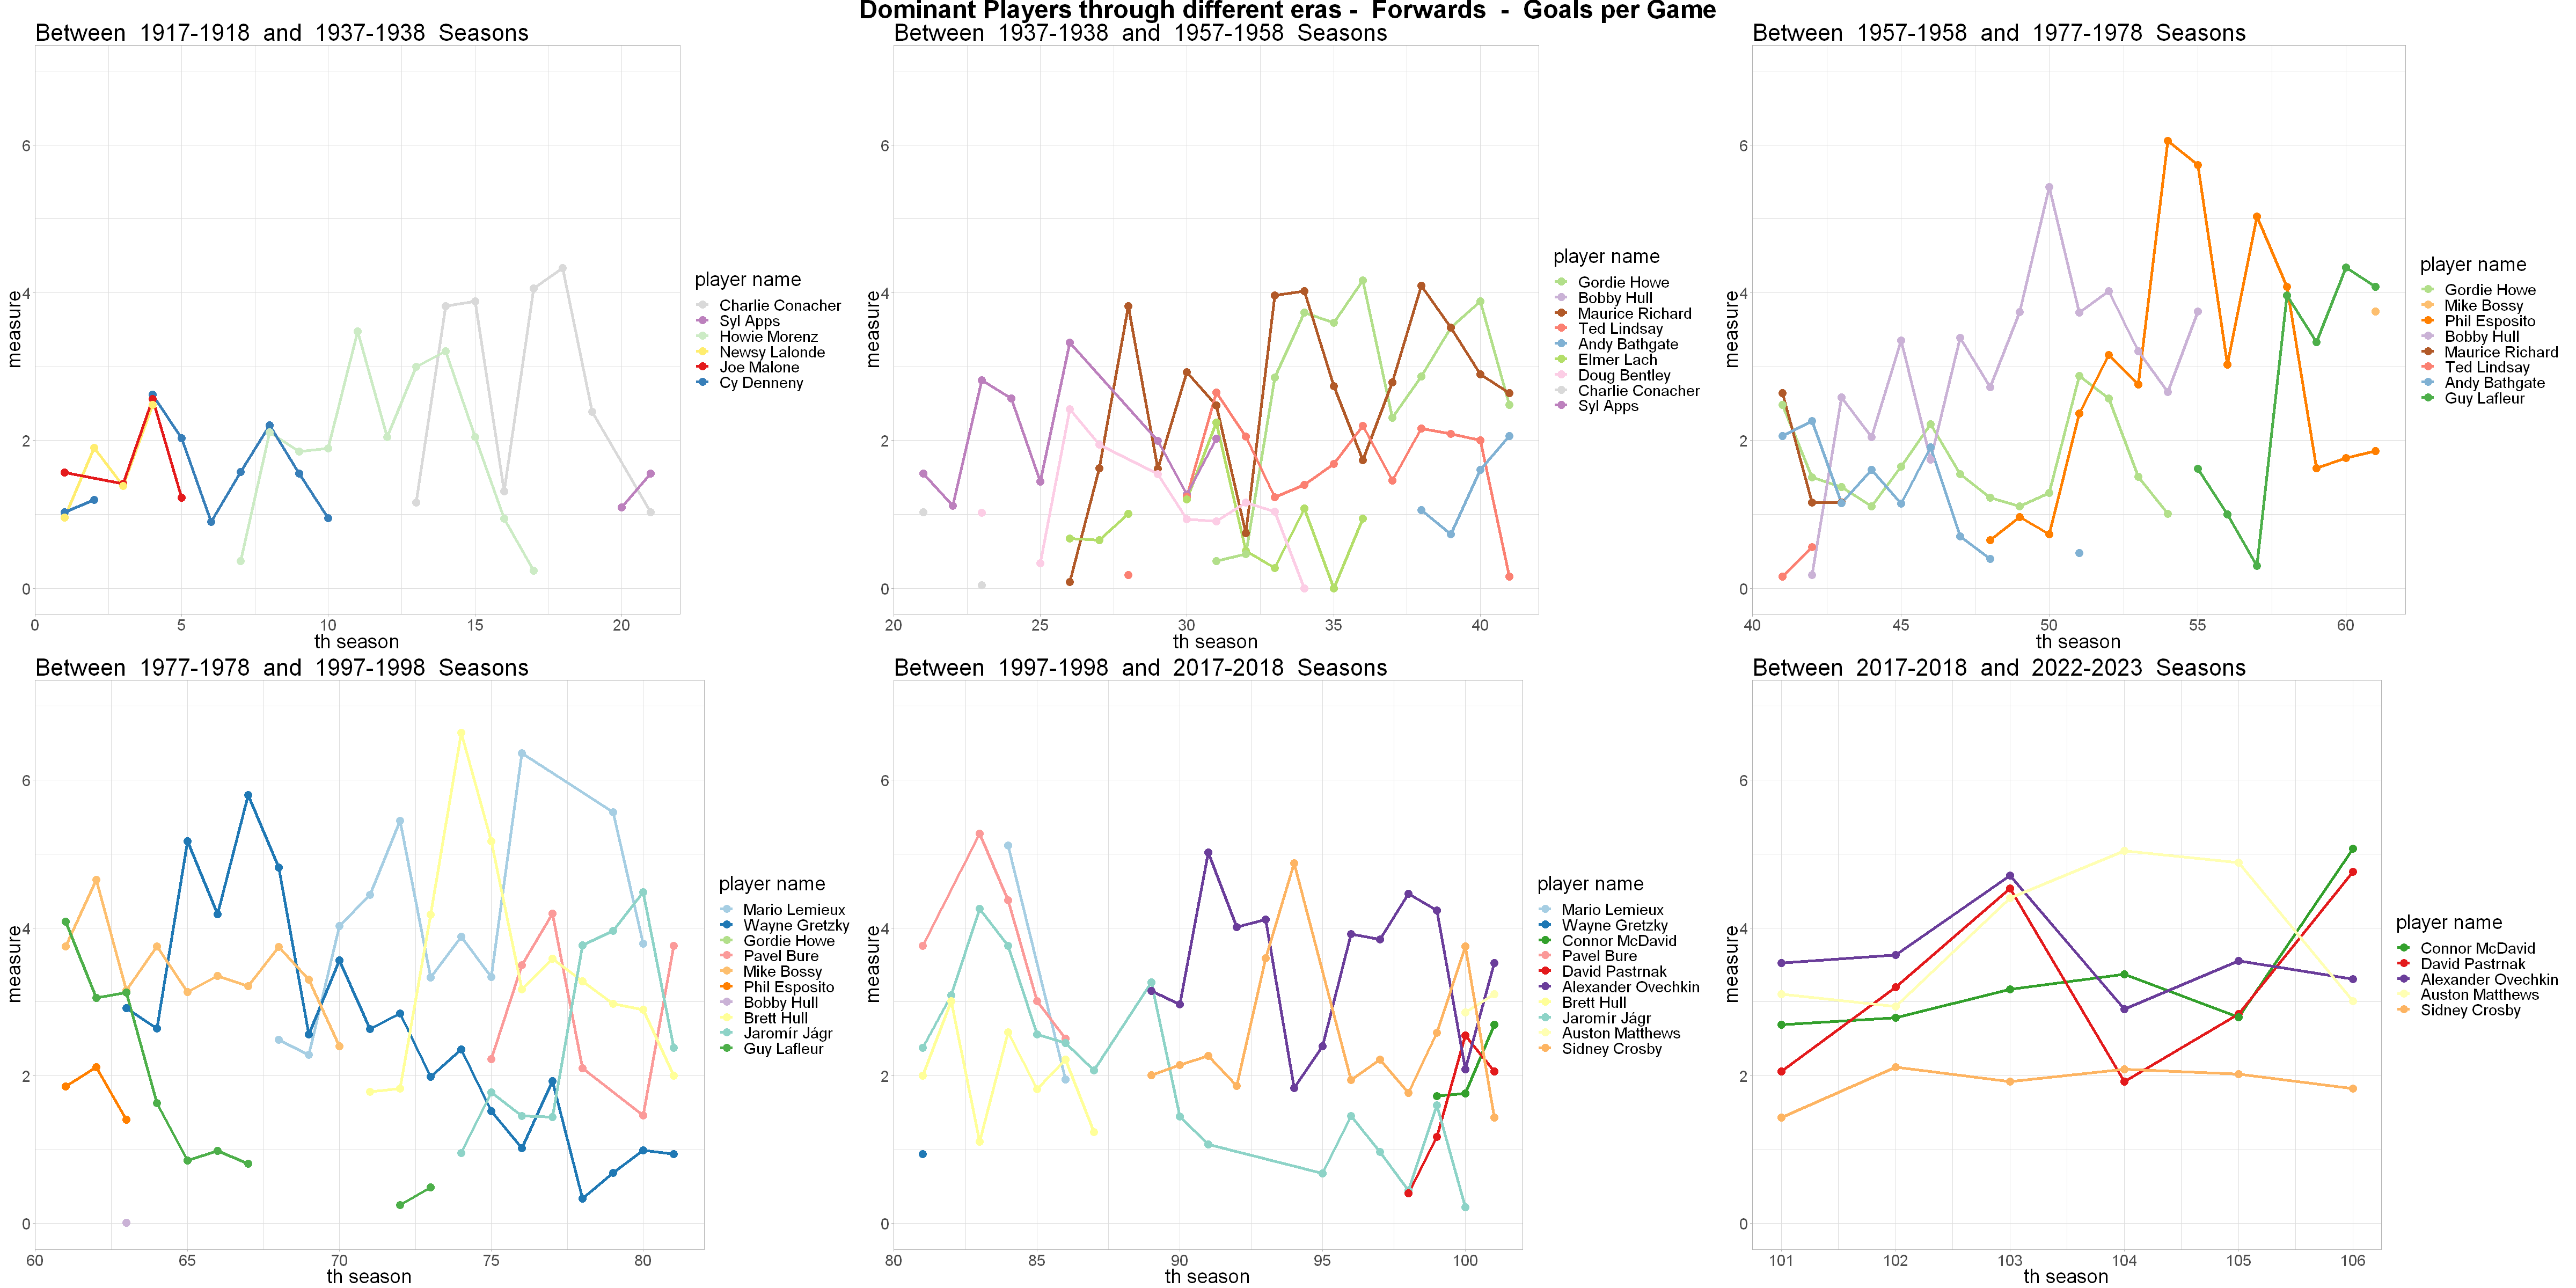

In [21]:
options(repr.plot.width = 40, repr.plot.height = 20)
create_era_comparison_plot(df = dominance_g_f, 
                        position = "forward", 
                        stat = "gpg", 
                        player_list = forward_legends, 
                        season_limits = eras_limits, 
                        title_position = "Forwards", 
                        max_y = 7)

Looking at the comparison of career peaks, we can see that Mario and Wayne joined by Phil Esposito and Brett Hull have the highest peaks of all players in the NHL history. On the next tier therea likes of Alexander Ovechkin, Bobby Hull, Maurice Richard or Miek Bossy who also consistently managed to achieve scores close or over 4 MADs over median player performance. 

#### Points Per Game - Defenders

##### Distribution of Points per Game by Season

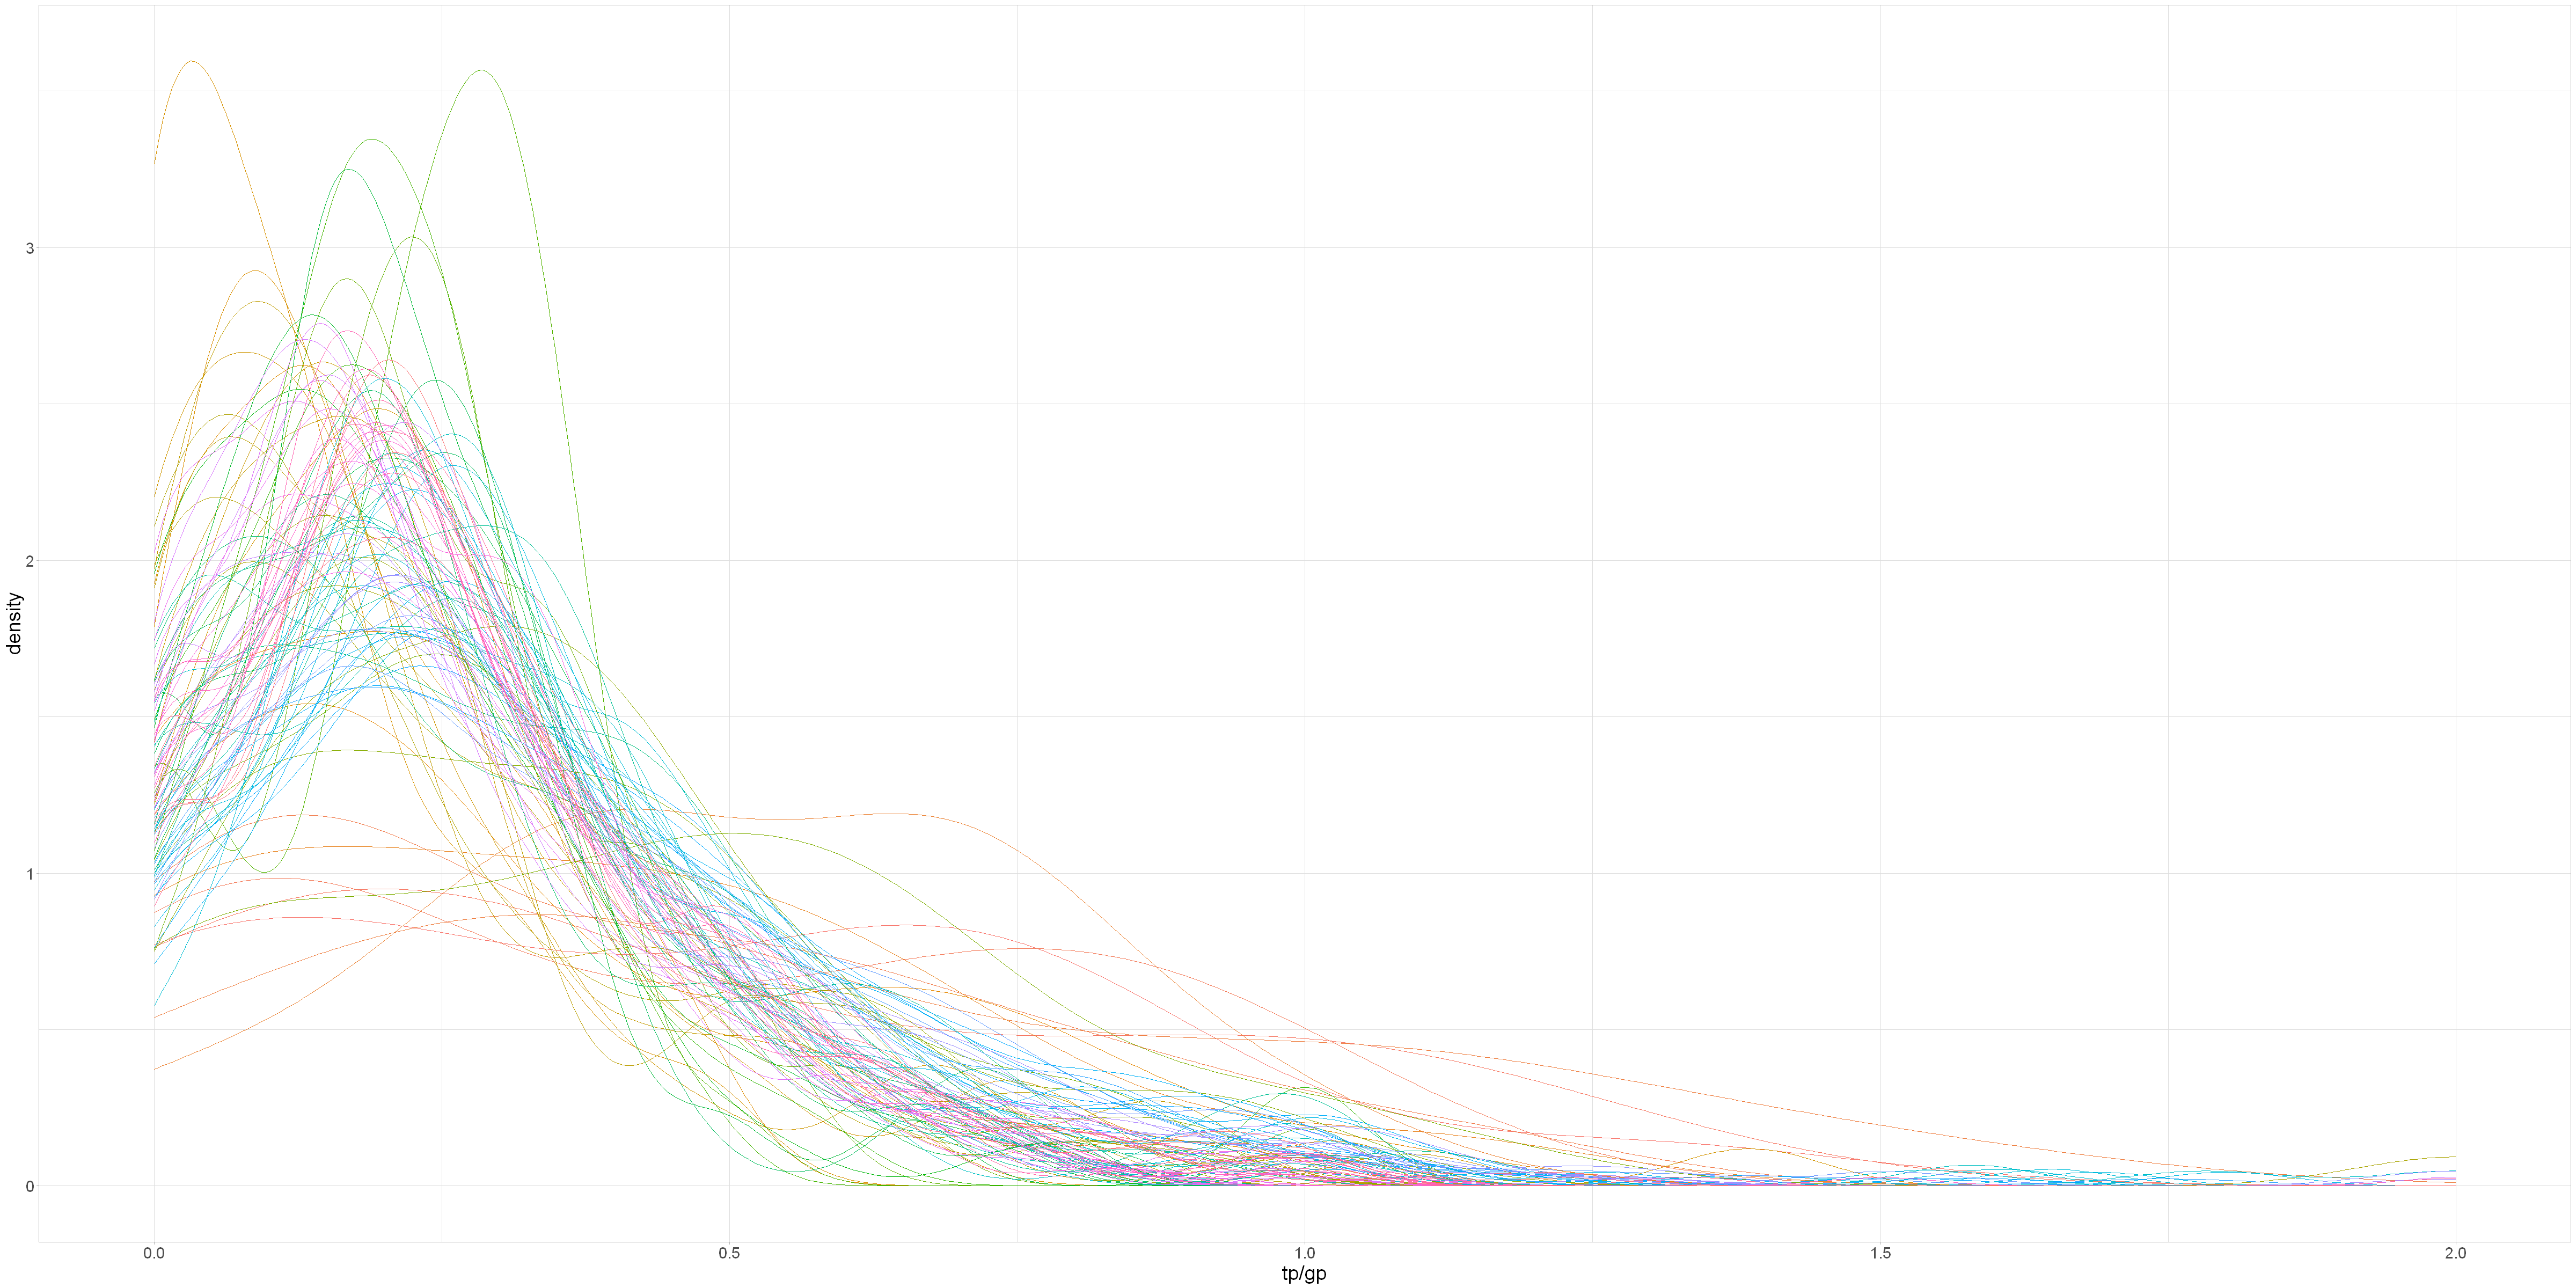

In [22]:
player_data %>%
  filter(regular_season == 1) %>%
  filter(grepl("D", position)) %>%
  ggplot(., aes(x = tp/gp, colour = season)) + 
  geom_density() + 
  def_plot_setup + 
  theme(legend.position = 'none')

##### Best Seasons

In [23]:
dominance_p_d <- create_comparative_measure(player_data, "defense", 1, avg_p)
head(dominance_p_d, 10)

u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,...,plus_minus,pm,avg_g,avg_p,avg_a,median_games,median_stat,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19145,Bobby Orr,58,1974-1975,L,Canada,0,D,1,80,...,80,101,0.5750000,1.687500,1.1125000,26,0.3947368,0.1374533,0.3000000,10.094336
19145,Bobby Orr,57,1973-1974,L,Canada,0,D,1,74,...,84,82,0.4324324,1.648649,1.2162162,43,0.3600000,0.1448670,0.3066667,9.263546
19145,Bobby Orr,54,1970-1971,L,Canada,0,D,1,78,...,124,91,0.4743590,1.782051,1.3076923,36,0.3593750,0.1704744,0.2909982,8.746493
19145,Bobby Orr,53,1969-1970,L,Canada,0,D,1,76,...,54,125,0.4342105,1.578947,1.1447368,20,0.3333333,0.1514484,0.2689380,8.649874
24034,Dit Clapper,13,1929-1930,R,Canada,0,D/F,1,44,...,0,38,0.9318182,1.386364,0.4545455,31,0.2529070,0.1356685,0.2403723,8.446994
19145,Bobby Orr,55,1971-1972,L,Canada,0,D,1,76,...,86,106,0.4868421,1.539474,1.0526316,37,0.3333333,0.1683209,0.2692308,7.546553
19145,Bobby Orr,56,1972-1973,L,Canada,0,D,1,63,...,56,99,0.4603175,1.603175,1.1428571,50,0.4000000,0.1716353,0.3164680,7.496750
79315,Hooley Smith,15,1931-1932,R,Canada,0,D/F,1,43,...,0,57,0.2558140,1.023256,0.7674419,19,0.2500000,0.1235500,0.2017276,6.649358
21321,Paul Coffey,72,1988-1989,L,Canada,0,D,1,75,...,-10,195,0.4000000,1.506667,1.1066667,19,0.3378378,0.1844710,0.2857143,6.618670


Looking at the table with best point per game in season performances among defenders, most of the places in the top 10 are occupied by a single player no other than Bobby Orr. Player who revolutionized his position like probably no other player in hockey history. His best season would be considered all time even if he was compared with forwards instead of defenders.

##### Highest Career Averages

In [24]:
career_p_dominance_d <- create_career_measure(dominance_p_d)
head(career_p_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.847557,9
Paul Coffey,3.844365,20
Denis Potvin,3.607396,15
Raymond Bourque,3.540624,22
Erik Karlsson,3.505355,13
Al MacInnis,3.365391,20
Brian Leetch,3.340435,17
Nicklas Lidström,2.920828,20
Sergei Zubov,2.887377,15


Among the top 10, we can see only players that come after 1970, since before Bobby Orr came into league the defenders did not partake as much in the team scoring. On the secodn position there is Paul Coffey who greatly benefited by playing with Wayne Gretzky for a significcant part of his career, on the third position there is then Denis Potivin.  

##### Comparison of Legendary Players

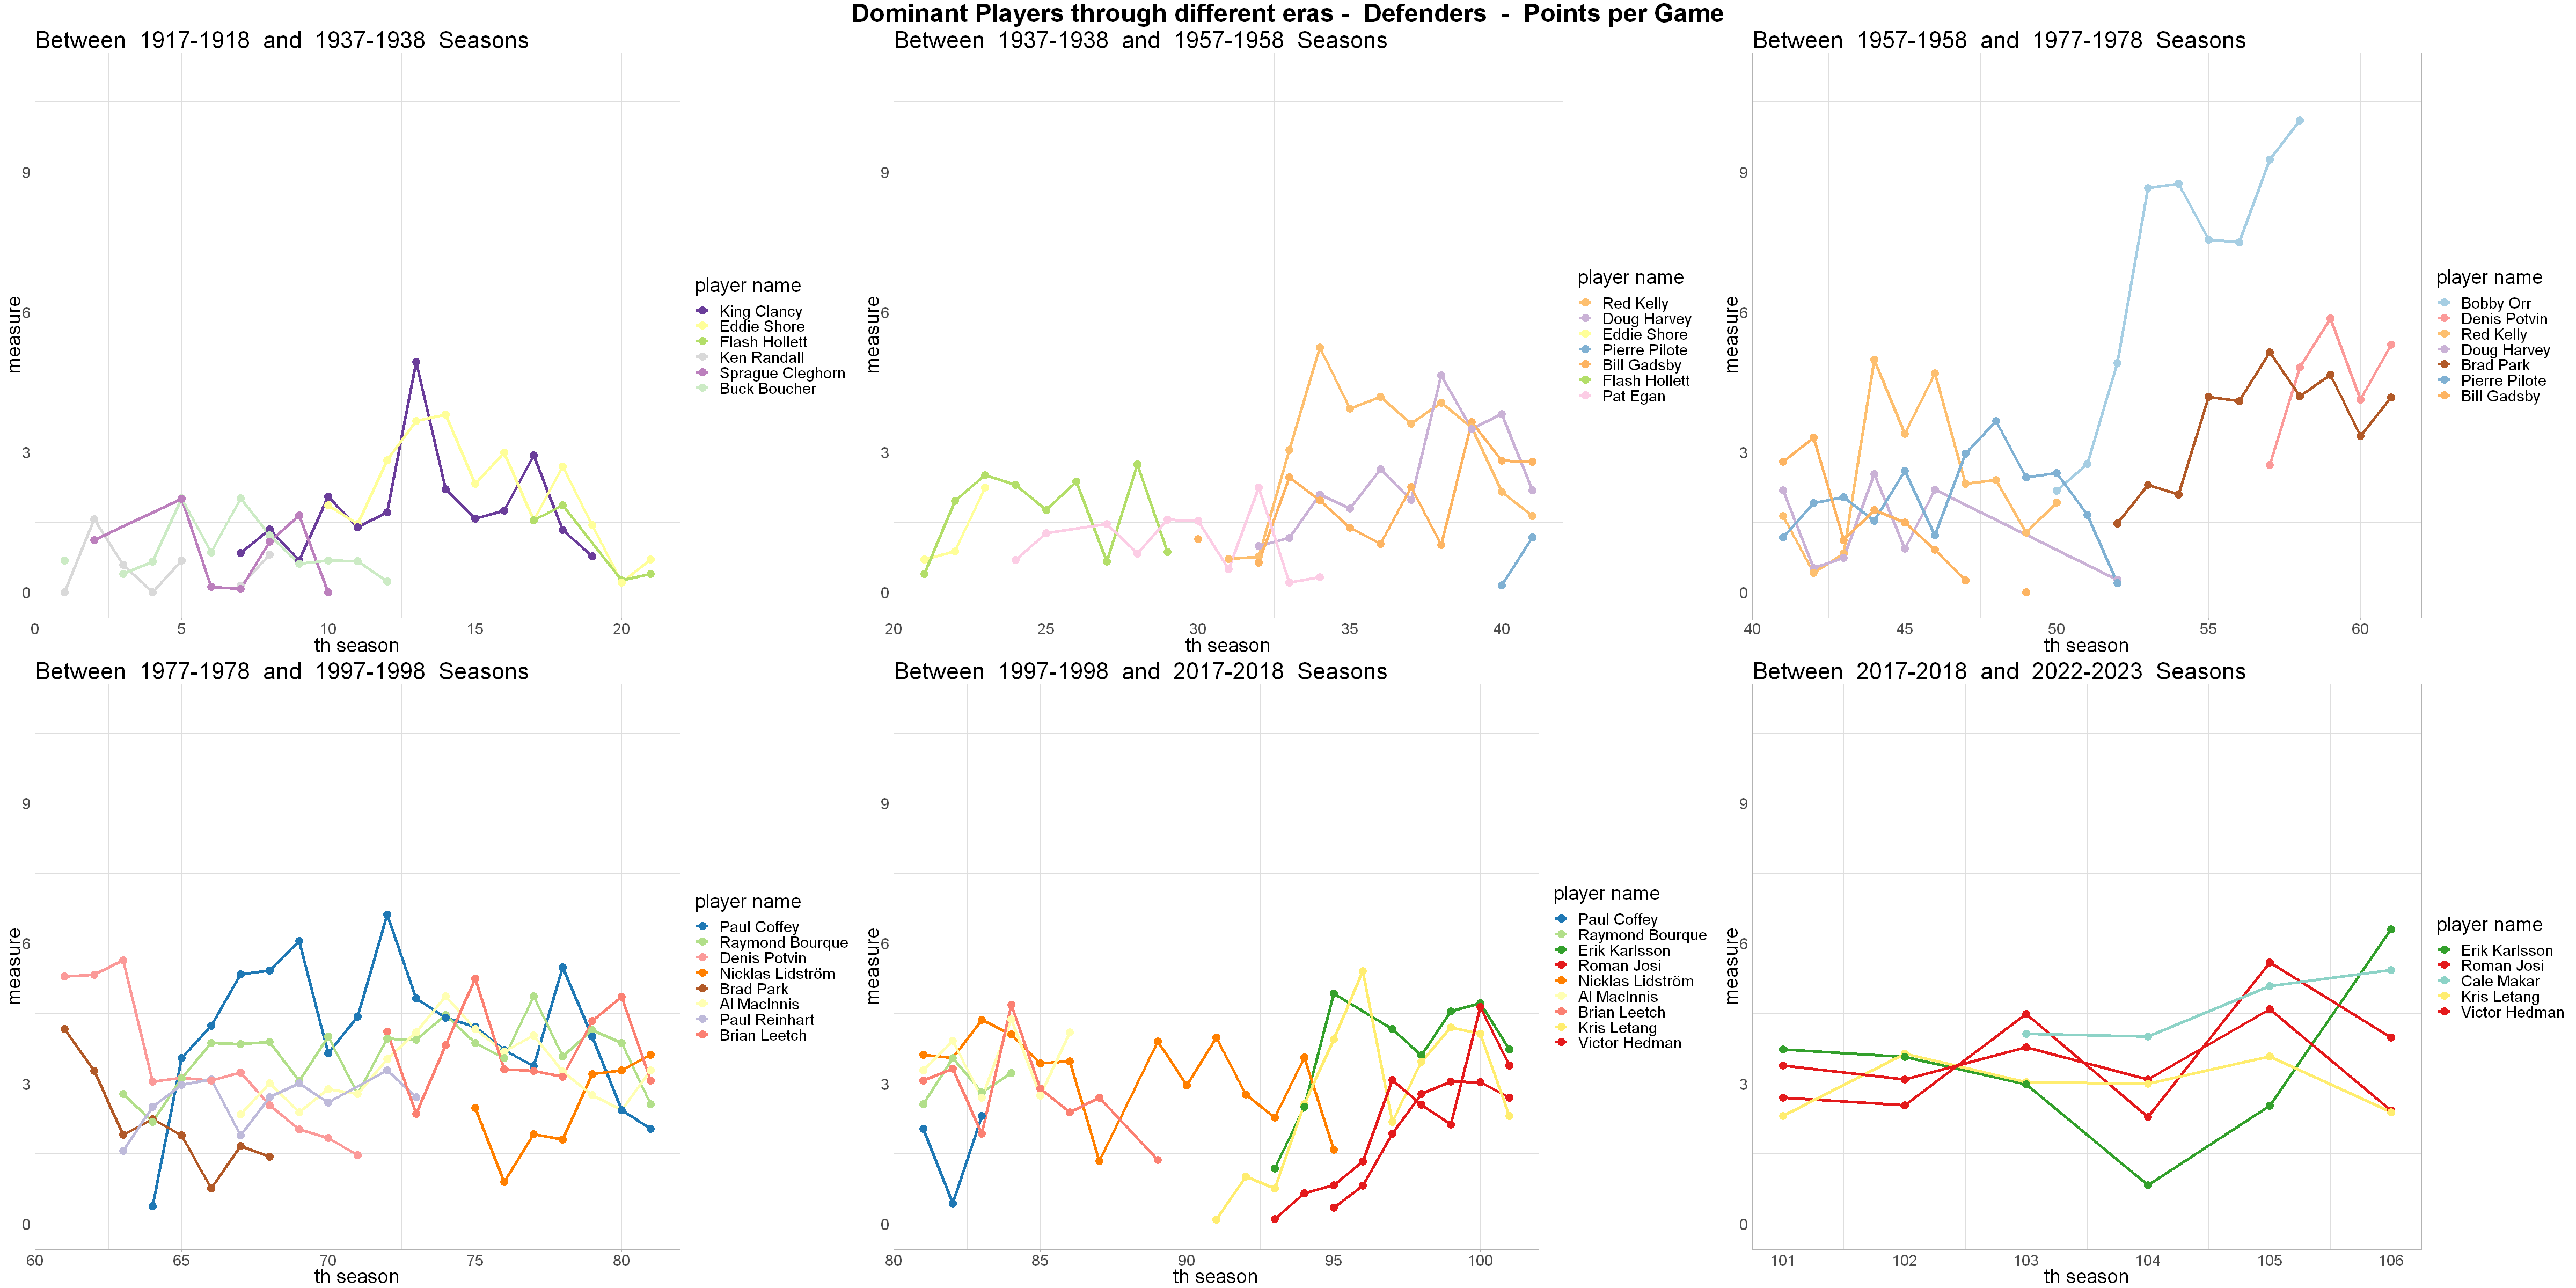

In [25]:
options(repr.plot.width = 40, repr.plot.height = 20)
create_era_comparison_plot(df = dominance_p_d, 
                        position="defender", 
                        stat = "ppg", 
                        player_list = defender_legends, 
                        season_limits = eras_limits, 
                        title_position = "Defenders", 
                        max_y = 11)

Looking at the comparison of peaks of the highest scoring defenders in the league history, we can again see how much better than everybody else Bobby Orr was. 

#### Goalkeepers - Save Percentage

##### Distribution of Save Percentage by Season

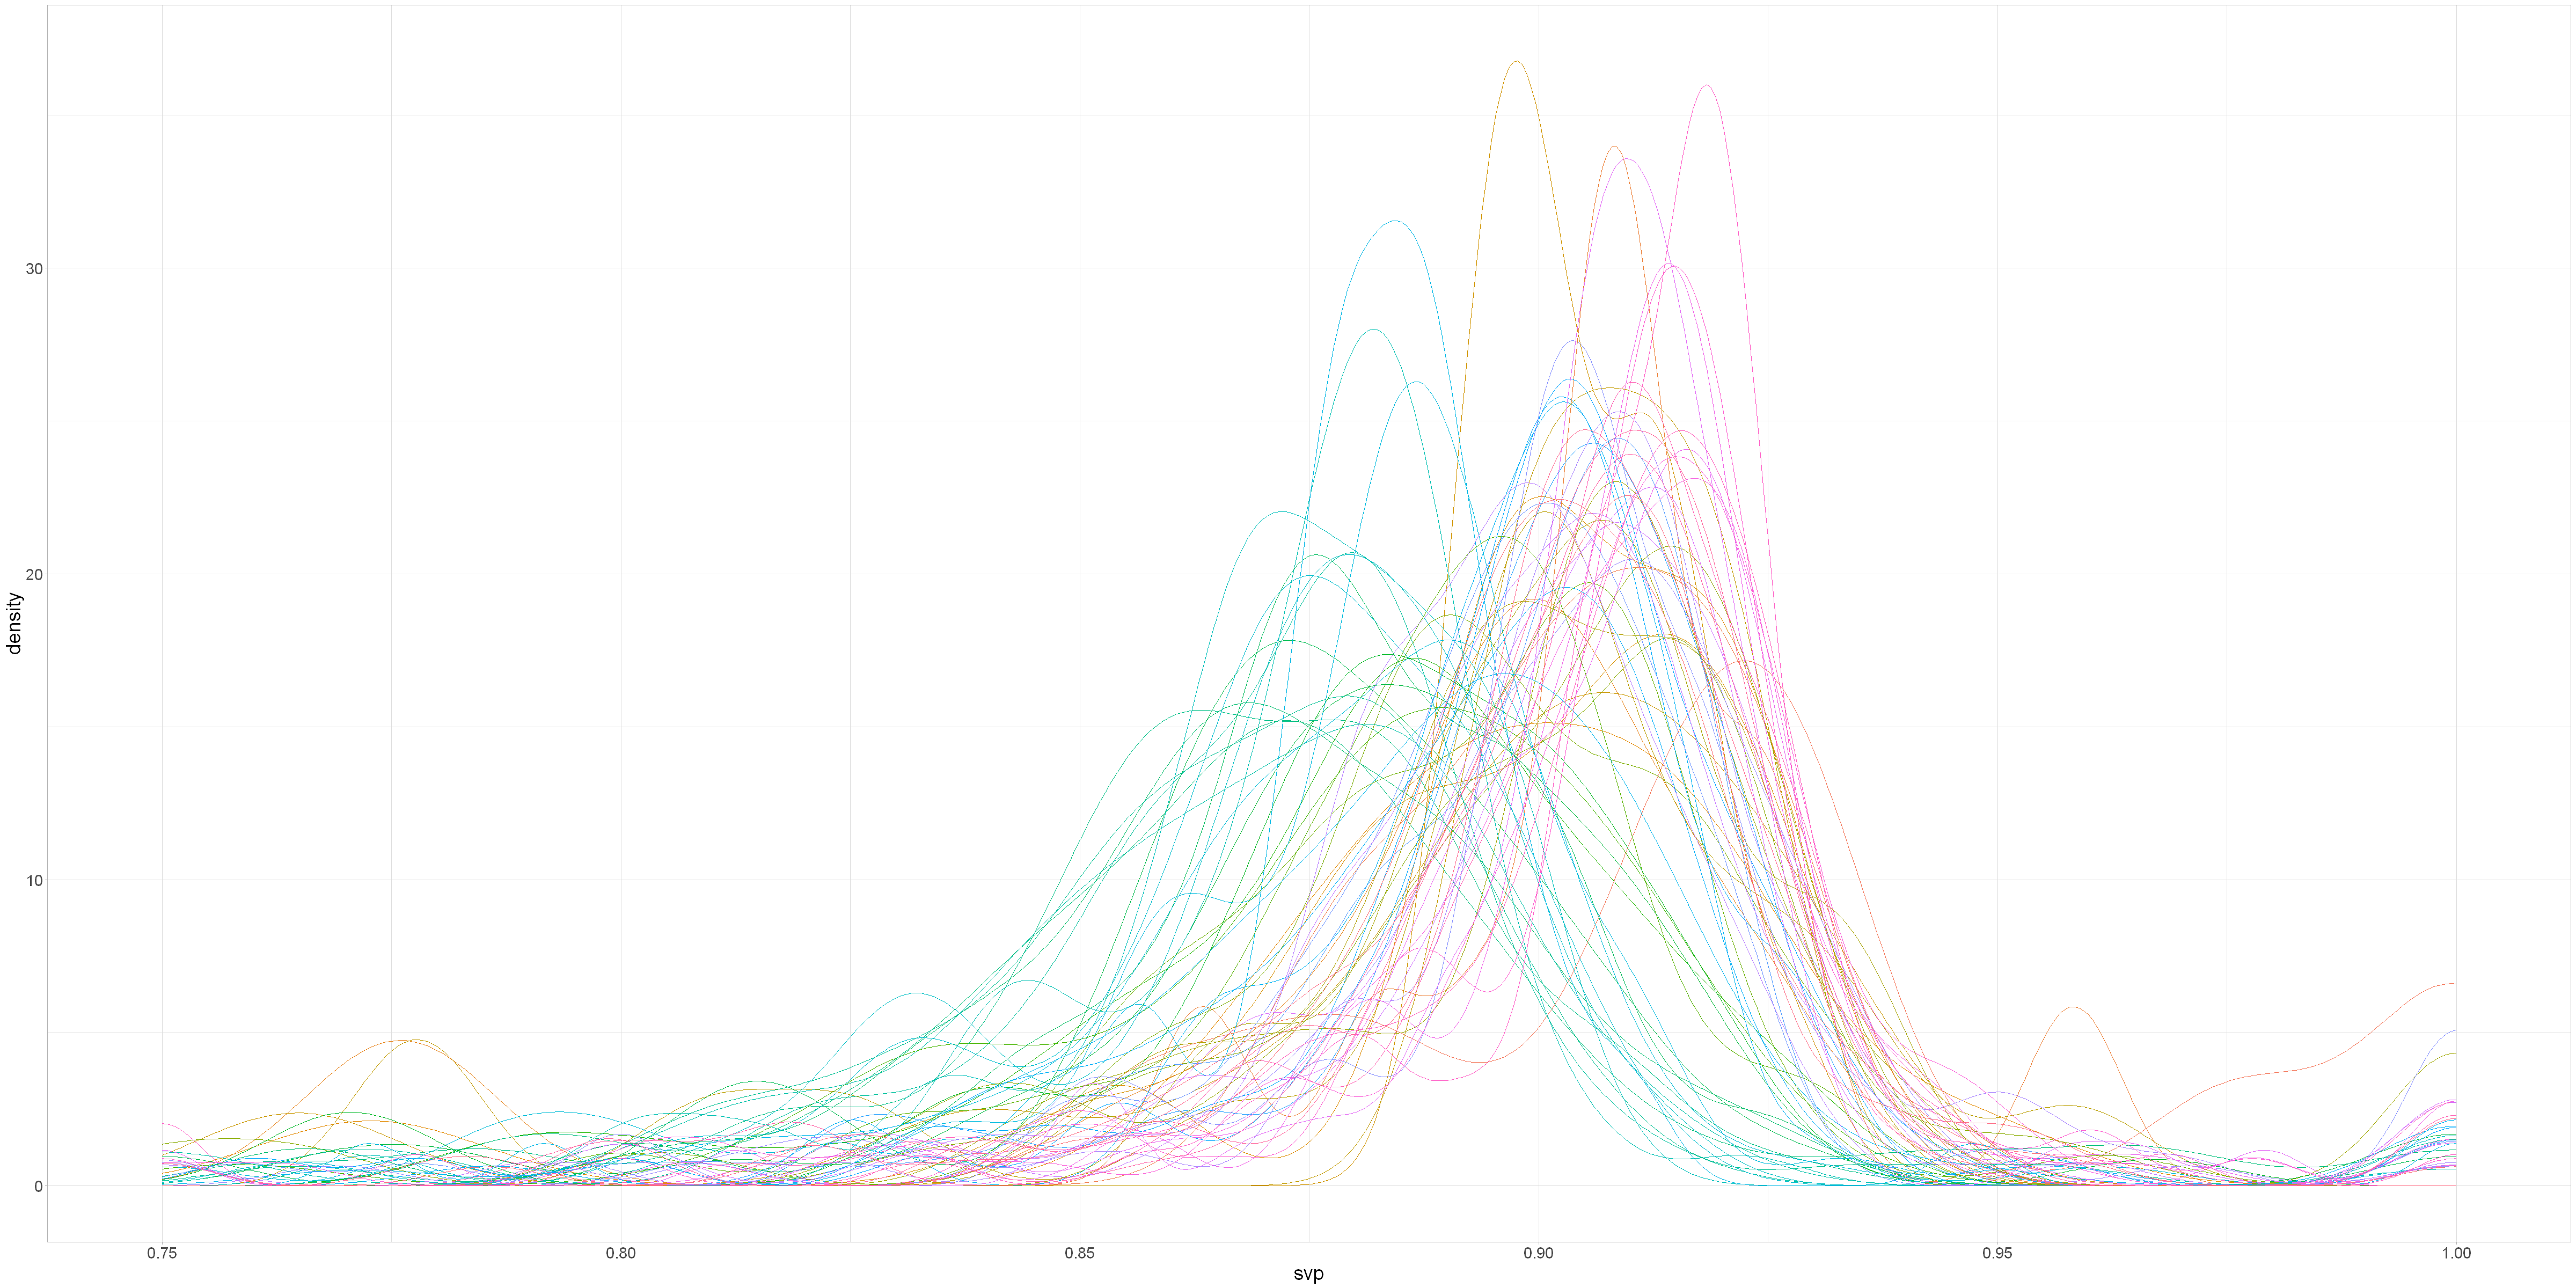

In [26]:
goalie_data %>%
  filter(regular_season == 1) %>%
  filter(grepl("G", position)) %>%
  ggplot(., aes(x = svp, colour = season)) + 
  xlim(0.75, 1) + 
  geom_density() + 
  def_plot_setup + 
  theme(legend.position = 'none')

#### Best Seasons 

In [27]:
dominance_svp <- create_comparative_measure(goalie_data, "goalie", 1, svp)
head(dominance_svp, 10)


u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,...,l,t,toi,gaa,svp,median_games,median_stat,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24032,Lorne Worsley,41,1957-1958,L,Canada,0,G,1,37,...,10,6,2220,2.3243,0.9271,11.0,0.90800,0.00504084,0.90860,3.670023
8666,David Aebischer,85,2001-2002,L,Switzerland,0,G,1,21,...,6,0,1184,1.7619,0.9312,17.0,0.90650,0.00800604,0.90580,3.172605
5526,José Théodore,85,2001-2002,R,Canada,0,G,1,67,...,24,10,3864,2.0299,0.9310,17.0,0.90650,0.00800604,0.90580,3.147624
11336,Brian Elliott,95,2011-2012,L,Canada,1,G,1,38,...,10,4,2235,1.5263,0.9403,16.0,0.91345,0.00845082,0.91380,3.135790
22714,Bernie Parent,57,1973-1974,L,Canada,0,G,1,73,...,13,12,4307,1.8630,0.9322,16.5,0.89350,0.01134189,0.89715,3.090314
78702,Jacques Plante,52,1968-1969,L,Canada,0,G,1,37,...,12,6,2138,1.8919,0.9404,9.0,0.90530,0.01141602,0.90530,3.074627
78702,Jacques Plante,41,1957-1958,L,Canada,0,G,1,57,...,14,8,3386,2.0877,0.9238,11.0,0.90800,0.00504084,0.90860,3.015370
8665,Dominik Hasek,80,1996-1997,L,Czechia,0,G,1,67,...,20,10,4037,2.2836,0.9297,16.0,0.90320,0.00926625,0.90320,2.859841
21308,Patrick Roy,75,1991-1992,L,Canada,0,G,1,67,...,22,8,3935,2.3134,0.9142,14.0,0.88600,0.01000755,0.88585,2.832861


The save percentage fo the goalkeepers is availaible only from 1956-1957 season. The table with the best season performances between this season and present includes probably the most suprising results of all the top perfomrmances until now. On the first place is no player to be expected to be here as Ken Dryden, Jaques Plante or Dominik Hasek but a less known goalie from 1950s and 1960s Lorne Worsley for his performance in 1957-1958 season. 

##### Carrer Highs

In [28]:
career_dominance_svp <- create_career_measure(dominance_svp)
head(career_dominance_svp, 10)

name,measure,n
<chr>,<dbl>,<int>
Ken Dryden,1.6550686,7
Dominik Hasek,1.4642589,14
Patrick Roy,1.2694727,18
Tony Esposito,1.0619151,16
Juuse Saros,0.9810694,7
Jacques Plante,0.9262237,17
Tuukka Rask,0.9121168,12
Johnny Bower,0.9021450,12
Chico Resch,0.8869732,13


The career highs are on the other hand led by expected well known names. On the first position is Ken Dryden goalie who played arguably on the most dominant team in the leagues history 1970s Montreal Canadiens followed by 90s and 00s legends Dominik Hasek and Patrick Roy. Only other player who achieved to have career average of MADs over median over 1 is Phil Esposito on  the fourth position. 

##### Comparison of Legendary Players

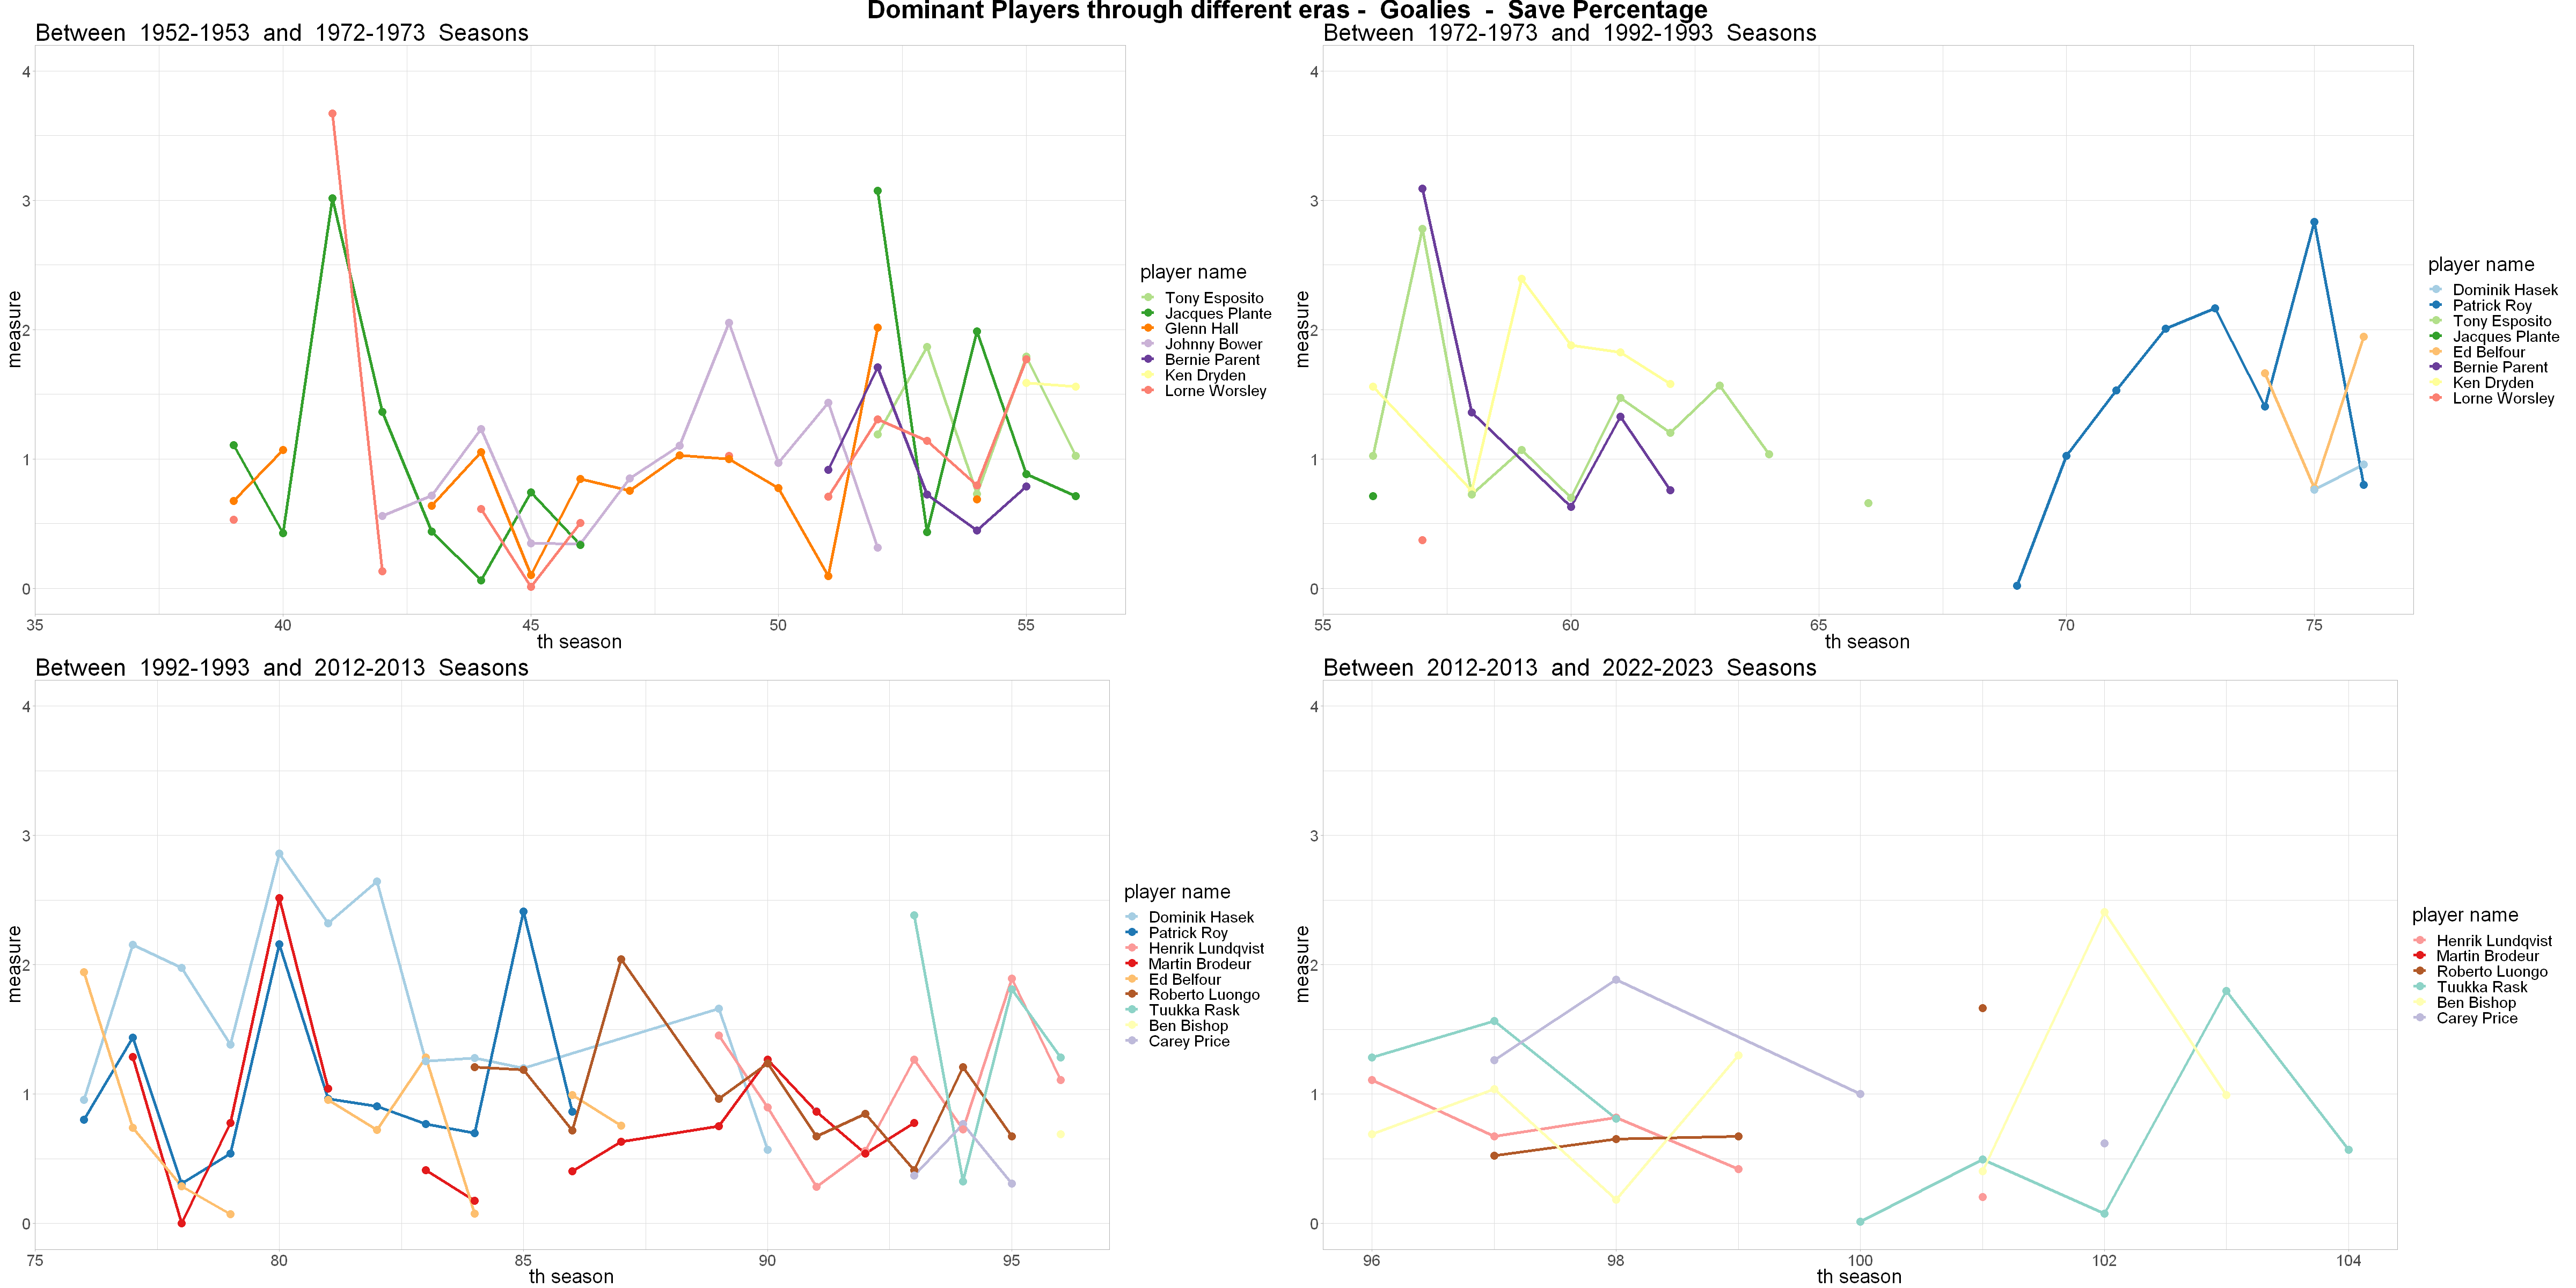

In [29]:
options(repr.plot.width = 40, repr.plot.height = 20)
create_era_comparison_plot(df = dominance_svp, 
                            position = "goalie", 
                            stat = "svp", 
                            player_list = goalie_legends, 
                            season_limits = eras_limits_g, 
                            title_position = "Goalies", 
                            max_y = 4)

Looking at the season performances of goalie legends we can see that Ken Dryden benefits greatly from retiring at the top of his game and season to season does not achieve the performance peaks of other all time greats as are Jaques Plante, Patrick Roy or Dominik Hasek. We can also infer that other goalkeeper who is also often mentioned among the all time greats and holds several league records Martin Brodeur benefited from his long career but season to season he has only  one where he was above 2 MADs above league median in save percentage. 

### 